<a href="https://colab.research.google.com/github/climatechange-ai-tutorials/citylearn/blob/main/citylearn_ccai_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.9.13


The following Python packages are required (takes about 3 mins to run to completion in Colab):

In [2]:
%%capture

# the environment we will be working with and its dependencies
!pip install gymnasium
!pip install nrel-pysam
!pip install simplejson
# TODO: update to install stable version from PyPi
!pip install --no-deps CityLearn==2.2b0

# to generate static figures
!pip install matplotlib
!pip install seaborn

# provide standard RL algorithms
!pip install --no-deps stable-baselines3
# !pip install stable-baselines3


# results submission
!pip install requests
!pip install beautifulsoup4

# progress bar
!pip install tqdm

We can now import the relevant modules, classes and functions used in the tutorial:

In [3]:
# system operations
import inspect
import os
import uuid
import warnings

# date and time
import datetime

# type hinting
from typing import Any

# User interaction
from ipywidgets import Button, HTML
from ipywidgets import Text, HBox, VBox

# data visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tqdm import tqdm

# data manipulation
from bs4 import BeautifulSoup
import math
import numpy as np
import pandas as pd
import random
import re
import requests
import simplejson as json

# cityLearn
from citylearn.agents.base import (
    BaselineAgent,
    Agent as RandomAgent
)
from citylearn.agents.rbc import HourRBC
from citylearn.agents.q_learning import TabularQLearning
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction
from citylearn.wrappers import (
    NormalizedObservationWrapper,
    StableBaselines3Wrapper,
    TabularQLearningWrapper,
    DiscreteActionWrapper
)

# RL algorithms
from stable_baselines3 import SAC, A2C, PPO, DDPG

Here we include some global settings we want applied for the remainder of the notebook:

In [4]:
# set all plotted figures without margins
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
%matplotlib inline

# ignore deprecation warnings
# warnings.filterwarnings('ignore', category=DeprecationWarning)

<a name="data-description"></a>
# Dataset Description
---

The `citylearn_challenge_2022_phase_all` dataset used in this tutorial is from [17 zero net energy (ZNE) single-family homes in the Sierra Crest Zero Net Energy community in Fontana, California](https://www.calmac.org/publications/CSIRDD_Sol4_EPRI_Grid-Integration-of-ZNE-Communities_FinalRpt_2017-01-27.pdf), which is pictured below. The buildings were studied for grid integration of zero net energy communities as part of the California Solar Initiative program specifically exploring the [impact of high penetration PV generation and on-site electricity storage](https://www.aceee.org/files/proceedings/2016/data/papers/10_1237.pdf). This dataset is the same as that used in [The CityLearn Challenge 2022](https://www.aicrowd.com/challenges/neurips-2022-citylearn-challenge) and represents a one-year period between August 1, 2016 and July 31, 2017.

<figure class="image">
  <img src="https://github.com/intelligent-environments-lab/CityLearn/blob/master/assets/images/fontana_elevations.png?raw=true"  width="400" alt="Building elevations in Sierra Crest Zero Net Energy community in Fontana, California.">
  <figcaption>Figure: Building elevations in Sierra Crest Zero Net Energy community in Fontana, California.</figcaption>
</figure>

Each building in the dataset is a single-family archetype that was constructed in the mid to late 2010s and has a gross floor area between 177 m<sup>2</sup> and 269 m<sup>2</sup>. The figure below shows the envelope and system characteristics of the buildings. The building envelope is made from high-performance materials for improved insulation and the buildings are equipped with high-efficiency appliances, electric heating and water heating systems. Each building also has a home energy management system as well as circuit-level monitoring that provides one-minute power time series data.

<figure class="image">
  <img src="https://github.com/intelligent-environments-lab/CityLearn/blob/master/assets/images/fontana_building_systems.png?raw=true"  width="400" alt="Building elevations in Sierra Crest Zero Net Energy community in Fontana, California.">
  <figcaption>Figure: Building systems in Sierra Crest Zero Net Energy community in Fontana, California.</figcaption>
</figure>

In the as-built community, eight of the 17 buildings are equipped with 6.4 kWh capacity batteries that have 5 kW power rating, 90\% round-trip efficiency, and 75\% depth-of-discharge. The installed PV capacity is 4 kW or 5 kW for homes with or without batteries, respectively.

The `citylearn_challenge_2022_phase_all` dataset is a transformed version of the as-built buildings and original circuit-level data that were provided by Electric Power Research Institute (EPRI), whom were stakeholders in the Sierra Crest Zero Net Energy community and a sponsor in The CityLearn Challenge 2022. This transformed version fixed data quality issues and addressed privacy concerns towards making the dataset open-source. The transformed dataset has the following modifications:

1. The power time series has been transformed to hourly energy data in kWh.
2. Data quality issues such as outliers and gaps were addressed using inter-quartile range (IQR) outlier detection, interpolation and supervised learning prediction modeling.
3. All buildings have 6.4 kWh capacity batteries with 5 kW power rating, and 90% round-trip efficiency. The depth-of-discharge is 100%.
4. Space cooling, space heating, domestic water heating and plug loads have been coupled together under non-shiftable loads by directly using the main meter.

The following projects have made use of this transformed dataset:
1. [MERLIN: Multi-agent offline and transfer learning for occupant-centric energy flexible operation of grid-interactive communities using smart meter data and CityLearn](https://doi.org/10.48550/arXiv.2301.01148)
2. [Combining Forecasting and Multi-Agent Reinforcement Learning Techniques on Power Grid Scheduling Task](https://doi.org/10.1109/EEBDA56825.2023.10090669)
3. [The CityLearn Challenge 2022: Overview, Results, and Lessons Learned](https://proceedings.mlr.press/v220/nweye23a.html)

## Loading the Dataset

The dataset is included in the CityLearn package installation which we will now read into memory. To read the dataset, all we need is the name that references it:

In [5]:
DATASET_NAME = 'citylearn_challenge_2022_phase_all'

> ⚠️ **NOTE**: To get the names of all datasets in CityLearn execute the `citylearn.data.Dataset.get_names` method:

In [6]:
display('All CityLearn datasets:', sorted(DataSet.get_names()))

'All CityLearn datasets:'

['baeda_3dem',
 'ca_alameda_county_neighborhood',
 'citylearn_challenge_2020_climate_zone_1',
 'citylearn_challenge_2020_climate_zone_2',
 'citylearn_challenge_2020_climate_zone_3',
 'citylearn_challenge_2020_climate_zone_4',
 'citylearn_challenge_2021',
 'citylearn_challenge_2022_phase_1',
 'citylearn_challenge_2022_phase_2',
 'citylearn_challenge_2022_phase_3',
 'citylearn_challenge_2022_phase_all',
 'citylearn_challenge_2023_phase_1',
 'citylearn_challenge_2023_phase_2_local_evaluation',
 'citylearn_challenge_2023_phase_2_online_evaluation_1',
 'citylearn_challenge_2023_phase_2_online_evaluation_2',
 'citylearn_challenge_2023_phase_2_online_evaluation_3',
 'citylearn_challenge_2023_phase_3_1',
 'citylearn_challenge_2023_phase_3_2',
 'citylearn_challenge_2023_phase_3_3',
 'tx_travis_county_neighborhood',
 'vt_chittenden_county_neighborhood']

The dataset includes a schema, which is a `JSON` representation of the environment. This schema defines a `root_directory` key-value where all files that are relevant to this dataset are stored as well as the name of each file. We will use this root directory and filenames to read in and visualize the dataset files:

In [7]:
schema = DataSet.get_schema(DATASET_NAME)
root_directory = schema['root_directory']

### Preview a Building Data File
We can now preview the data files for one of the buildings in the `citylearn_challenge_2022_phase_all` dataset.

In [8]:
# change the suffix number in the next code line to a
# number between 1 and 17 to preview other buildings
building_name = 'Building_2'

filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(root_directory, filename)
building_data = pd.read_csv(filepath)
display(building_data.head())

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,heating_demand,solar_generation
0,7,24,7,0,NaN,NaN,NaN,2.188750,0.0,0.0,0.0,0.0
1,8,1,1,0,NaN,NaN,NaN,1.370667,0.0,0.0,0.0,0.0
2,8,2,1,0,NaN,NaN,NaN,1.101250,0.0,0.0,0.0,0.0
3,8,3,1,0,NaN,NaN,NaN,0.543217,0.0,0.0,0.0,0.0
4,8,4,1,0,NaN,NaN,NaN,0.542833,0.0,0.0,0.0,0.0


The `month`, `hour`, `day_type` and `daylight_savings_status` define the temporal dimension of the building loads. `indoor_dry_bulb_temperature`, `average_unmet_cooling_setpoint_difference` and `indoor_relative_humidity` are null values in the entire time series since they are not provided in the original dataset from the real-world building. For the same reason, `dhw_demand`, `cooling_demand` and `heating_demand` have zero values throughout the time series as they have been coupled with the `non_shiftable_load`.

The use-case of this dataset is to learn to use battery-PV system to satisfy these non-shiftable loads. The `non_shiftable_load` and `solar_generation` time series for the building are plotted below:

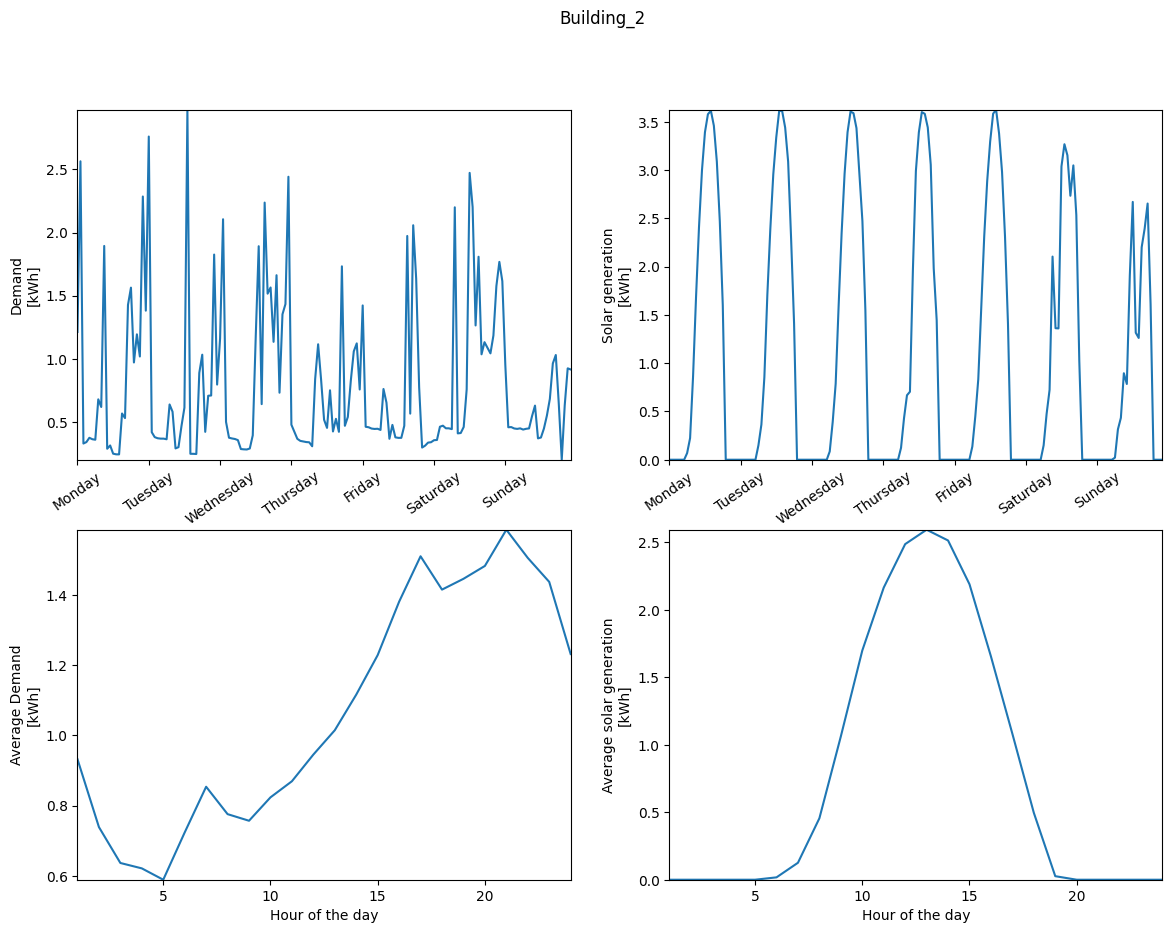

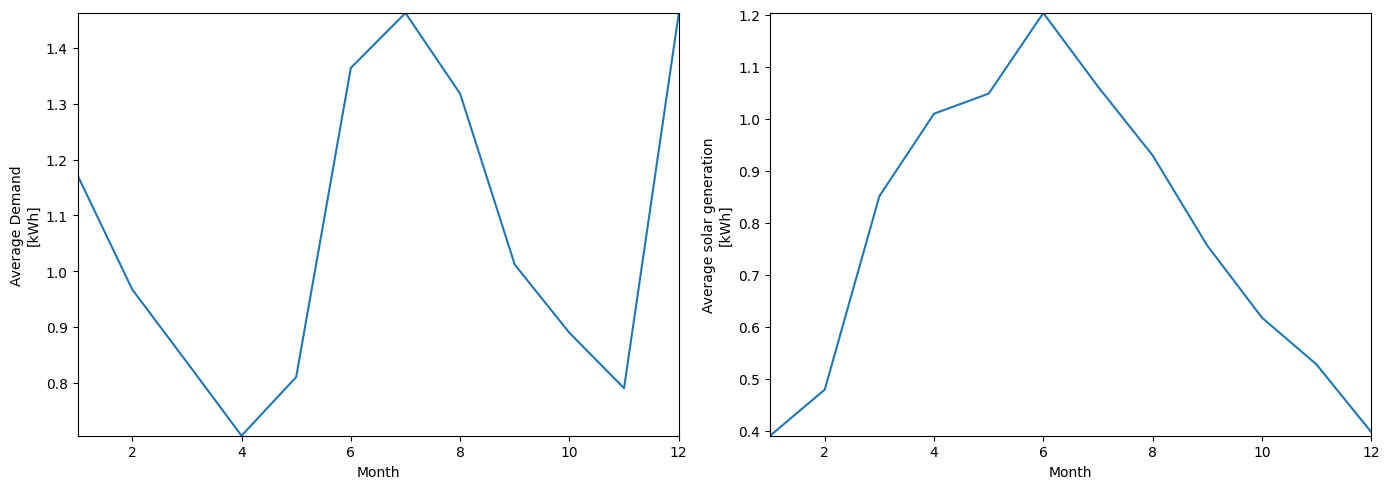

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming building_data is a DataFrame with 'hour', 'month', and 'day' columns
# Aggregating data by hour of the day
hourly_data = building_data.groupby('hour').mean()

# Aggregating data by month
monthly_data = building_data.groupby('month').mean()

# List of month names starting from August
# month_names = ['August', 'September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May', 'June', 'July']

fig, axs = plt.subplots(2, 2, figsize=(14, 10))


# 7392, 7559


day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Original plots
x = building_data[7392: 7559].index
y1 = building_data[7392: 7559]['non_shiftable_load']
y2 = building_data[7392: 7559]['solar_generation'] / 1000 * 5.0

axs[0, 0].plot(x, y1)
axs[0, 0].set_xlabel('Hour')
axs[0, 0].set_ylabel('Demand\n[kWh]')

axs[0, 0].set_xticks(x[::24])  # Set x-ticks every 730 hours
axs[0, 0].set_xticklabels(day_names)  # Label ticks with month names
plt.setp(axs[0, 0].get_xticklabels(), rotation=35)  # Rotate tick labels by 90 degrees



axs[0, 1].plot(x, y2)
axs[0, 1].set_xlabel('Hour')
axs[0, 1].set_ylabel('Solar generation\n[kWh]')
# axs[0, 1].set_xticks(range(0, len(building_data[7392: 7559]), 24))  # Set x-ticks every 730 hours
# axs[0, 1].set_xticklabels(day_names)  # Label ticks with month names
# plt.setp(axs[0, 1].get_xticklabels(), rotation=90)  # Rotate tick labels by 90 degrees
axs[0, 1].set_xticks(x[::24])  # Set x-ticks every 730 hours
axs[0, 1].set_xticklabels(day_names)  # Label ticks with month names
plt.setp(axs[0, 1].get_xticklabels(), rotation=35)  # Rotate tick labels by 90 degrees


# Plotting non-shiftable load aggregated by hour of the day
axs[1, 0].plot(hourly_data.index, hourly_data['non_shiftable_load'])
axs[1, 0].set_xlabel('Hour of the day')
axs[1, 0].set_ylabel('Average Demand\n[kWh]')

# Plotting solar generation aggregated by hour of the day
axs[1, 1].plot(hourly_data.index, hourly_data['solar_generation']/ 1000 * 5.0)
axs[1, 1].set_xlabel('Hour of the day')
axs[1, 1].set_ylabel('Average solar generation\n[kWh]')

# Plotting non-shiftable load aggregated by month
fig_month, axs_month = plt.subplots(1, 2, figsize=(14, 5))
axs_month[0].plot(monthly_data.index, monthly_data['non_shiftable_load'])
axs_month[0].set_xlabel('Month')
axs_month[0].set_ylabel('Average Demand\n[kWh]')

# Plotting solar generation aggregated by month
axs_month[1].plot(monthly_data.index, monthly_data['solar_generation']/ 1000 * 5.0)
axs_month[1].set_xlabel('Month')
axs_month[1].set_ylabel('Average solar generation\n[kWh]')

fig.suptitle(building_name)
plt.tight_layout()

# Save the figure
fig.savefig('building_data_plots.png', dpi=300)

# Show the plot
plt.show()

In [10]:
methods = ['RB', 'SAC', 'PPO', 'DDPG', 'A2C']
metrics = ['Cost', '< 10', '>90', 'Nbr of Back up', 'Training time', 'Nbr episodes']

# Example data for each method (replace with your actual data)
results = {
    'RB': [0.74, 20, 14, 34, '0', 0],
    'SAC': [0.64, 2, 0, 2, '26m', 200],
    'PPO': [0.65, 5, 7, 12, '23m', 200],
    'DDPG': [0.63, 6, 9, 15, '13m', 200],
    'A2C': [0.86, 21, 7, 28, '20m', 2000]
}

# Function to generate a single LaTeX table
def generate_latex_table(methods, metrics, results):
    latex_code = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|c|" + "c|" * len(metrics) + "}\n\\hline\n"
    latex_code += "Method & " + " & ".join(metrics) + " \\\\\n\\hline\n"
    for method in methods:
        latex_code += method + " & " + " & ".join(map(str, results[method])) + " \\\\\n\\hline\n"
    latex_code += "\\end{tabular}\n\\caption{Results for each method}\n\\end{table}\n"
    return latex_code

# Generate and print the LaTeX table
print(generate_latex_table(methods, metrics, results))

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
Method & Cost & < 10 & >90 & Nbr of Back up & Training time & Nbr episodes \\
\hline
RB & 0.74 & 20 & 14 & 34 & 0 & 0 \\
\hline
SAC & 0.64 & 2 & 0 & 2 & 26m & 200 \\
\hline
PPO & 0.65 & 5 & 7 & 12 & 23m & 200 \\
\hline
DDPG & 0.63 & 6 & 9 & 15 & 13m & 200 \\
\hline
A2C & 0.86 & 21 & 7 & 28 & 20m & 2000 \\
\hline
\end{tabular}
\caption{Results for each method}
\end{table}



In [11]:
results

{'RB': [0.74, 20, 14, 34, '0', 0],
 'SAC': [0.64, 2, 0, 2, '26m', 200],
 'PPO': [0.65, 5, 7, 12, '23m', 200],
 'DDPG': [0.63, 6, 9, 15, '13m', 200],
 'A2C': [0.86, 21, 7, 28, '20m', 2000]}

In [12]:
schema

{'random_seed': 2022,
 'root_directory': '/Users/leobenac/Desktop/Derms/CityLearn/dermsvenv/lib/python3.9/site-packages/citylearn/data/datasets/citylearn_challenge_2022_phase_all',
 'central_agent': False,
 'simulation_start_time_step': 0,
 'simulation_end_time_step': 8759,
 'episode_time_steps': None,
 'rolling_episode_split': False,
 'random_episode_split': False,
 'seconds_per_time_step': 3600,
 'observations': {'month': {'active': True, 'shared_in_central_agent': True},
  'day_type': {'active': True, 'shared_in_central_agent': True},
  'hour': {'active': True, 'shared_in_central_agent': True},
  'daylight_savings_status': {'active': False,
   'shared_in_central_agent': True},
  'outdoor_dry_bulb_temperature': {'active': True,
   'shared_in_central_agent': True},
  'outdoor_dry_bulb_temperature_predicted_6h': {'active': True,
   'shared_in_central_agent': True},
  'outdoor_dry_bulb_temperature_predicted_12h': {'active': True,
   'shared_in_central_agent': True},
  'outdoor_dry_bulb_

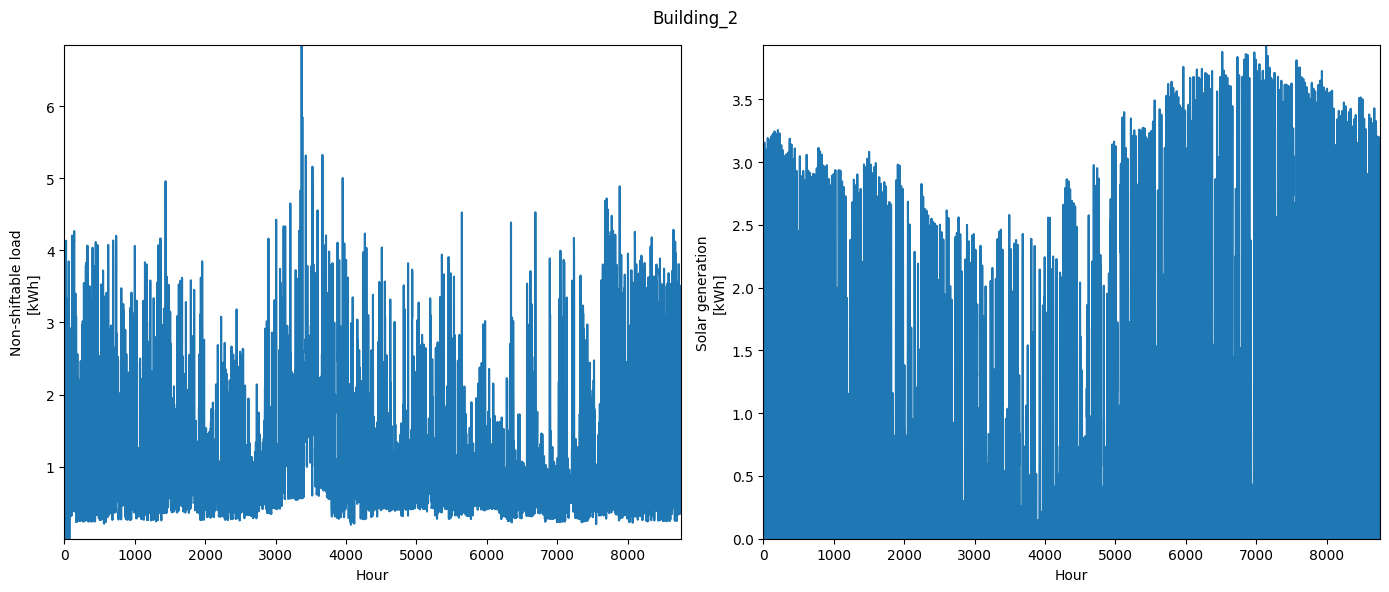

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
x = building_data.index
y1 = building_data['non_shiftable_load']
y2 = building_data['solar_generation'] / 1000 * 5.0
axs[0].plot(x, y1)
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Non-shiftable load\n[kWh]')
axs[1].plot(x, y2)
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Solar generation\n[kWh]')
fig.suptitle(building_name)
plt.tight_layout()
plt.show()

### Preview Weather File

Other supplemental data in the dataset include [TMY3 weather data from the Los Angeles International Airport weather station](https://energyplus.net/weather-location/north_and_central_america_wmo_region_4/USA/CA/USA_CA_Los.Angeles.Intl.AP.722950_TMY3) that is representative of a typical meteorological year in the Los Angeles International Airport location. All buildings in this dataset reference the same weather file as previewed:

In [14]:
filename = schema['buildings'][building_name]['weather']
filepath = os.path.join(root_directory, filename)
weather_data = pd.read_csv(filepath)
display(weather_data.head())

,outdoor_dry_bulb_temperature,outdoor_relative_humidity,diffuse_solar_irradiance,direct_solar_irradiance,outdoor_dry_bulb_temperature_predicted_6h,outdoor_dry_bulb_temperature_predicted_12h,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
0,20.0,84.0,0.0,0.0,18.3,22.8,20.0,81.0,68.0,81.0,25.0,964.0,0.0,100.0,815.0,0.0
1,20.1,79.0,0.0,0.0,19.4,22.8,19.4,79.0,71.0,87.0,201.0,966.0,0.0,444.0,747.0,0.0
2,19.7,78.0,0.0,0.0,21.1,22.2,19.4,73.0,73.0,87.0,420.0,683.0,0.0,592.0,291.0,0.0
3,19.3,78.0,0.0,0.0,22.2,22.8,19.4,71.0,71.0,90.0,554.0,522.0,0.0,491.0,153.0,0.0
4,18.9,78.0,0.0,0.0,21.7,22.2,18.9,73.0,71.0,90.0,778.0,444.0,0.0,734.0,174.0,0.0


The weather file has fields that describe the outdoor dry-bulb temperature, relative humidity, diffuse and direct solar irradiance, as well as their 6 hour, 12 hour and 24 hour forecasts. In this dataset, the forecasts are perfect forecasts for example, the 6 hour outdoor dry-bulb temperature forecast at a certain time step is equal to the temperature 6 hours later.

We can also plot this weather data to understand it better:

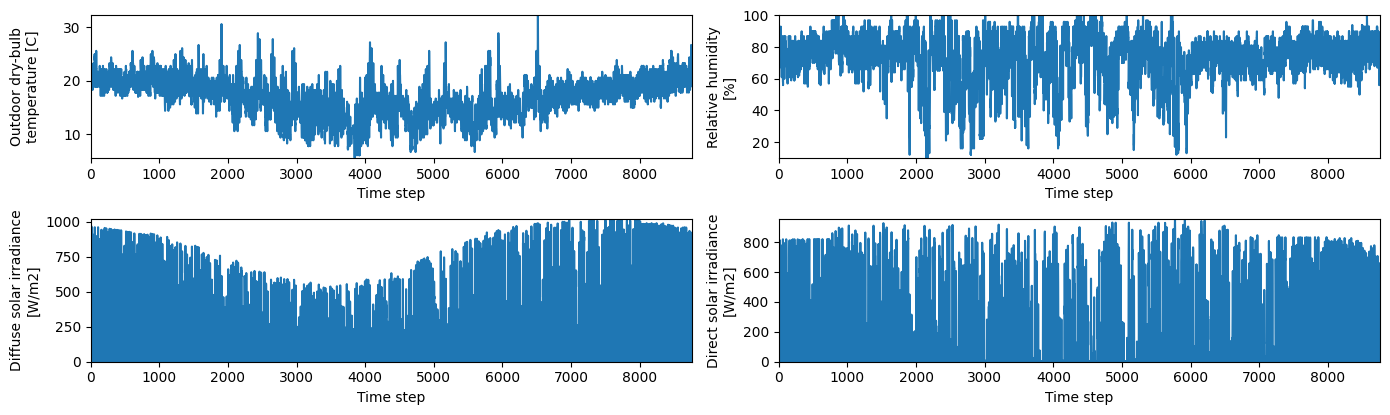

In [15]:
columns = [
    'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity',
    'diffuse_solar_irradiance', 'direct_solar_irradiance'
]
titles = [
    'Outdoor dry-bulb\ntemperature [C]', 'Relative humidity\n[%]',
    'Diffuse solar irradiance\n[W/m2]', 'Direct solar irradiance\n[W/m2]'
]
fig, axs = plt.subplots(2, 2, figsize=(14, 4.25))
x = weather_data.index

for ax, c, t in zip(fig.axes, columns, titles):
    y = weather_data[c]
    ax.plot(x, y)
    ax.set_xlabel('Time step')
    ax.set_ylabel(t)

fig.align_ylabels()
plt.tight_layout()
plt.show()

### Preview Electricity Price Data

The electricity rate-plan for the dataset is that of the community's utility provider, [Southern California Edison](https://www.sce.com/residential/rates/Time-Of-Use-Residential-Rate-Plans). We adopt their _TOU-D-PRIME_ rate plan summarized in table below, which is designed for customers with residential batteries where electricity is cheapest in the early morning and late at night, and cheaper during off-peak months of October-May. Meanwhile, electricity is cheaper on weekends for peak hours of 4 PM-9 PM in June-September.

Table: Time-Of-Use rate plan ($/kWh).

| | June-September |  | October-May |  |
|---|---|---|---|---|
| **Time** | **Weekday** | **Weekend** | **Weekday** | **Weekend** |
| 8 AM-4 PM | 0.21 | 0.21 | 0.20 | 0.20 |
| 4 PM-9 PM | 0.54 | 0.40 | 0.50 | 0.50 |
| 9 PM-8 AM | 0.21 | 0.21 | 0.20 | 0.20 |

The electricity pricing time series is shown below. It has four fields including perfect forecast of the pricing 6, 12 and 24 hours ahead.

In [16]:
filename = schema['buildings'][building_name]['pricing']
filepath = os.path.join(root_directory, filename)
pricing_data = pd.read_csv(filepath)
display(pricing_data.head())

,electricity_pricing,electricity_pricing_predicted_6h,electricity_pricing_predicted_12h,electricity_pricing_predicted_24h
0,0.22,0.22,0.22,0.22
1,0.22,0.22,0.22,0.22
2,0.22,0.22,0.22,0.22
3,0.22,0.22,0.22,0.22
4,0.22,0.22,0.54,0.22


### Preview Carbon Intensity Data

Another supplementary data in the `citylearn_challenge_2022_phase_all` dataset is the grid carbon intensity time series descring the CO<sub>2</sub> equivalent of greenhouse gases that are emitted for every unit kWh of energy consumption. This carbon intensity data were provided by EPRI and the time series is shown below:

In [17]:
filename = schema['buildings'][building_name]['carbon_intensity']
filepath = os.path.join(root_directory, filename)
carbon_intensity_data = pd.read_csv(filepath)
display(carbon_intensity_data.head())

,carbon_intensity
0,0.170724
1,0.157319
2,0.154503
3,0.150945
4,0.151820


We also preview the carbon intensity time series on a pair of axes:

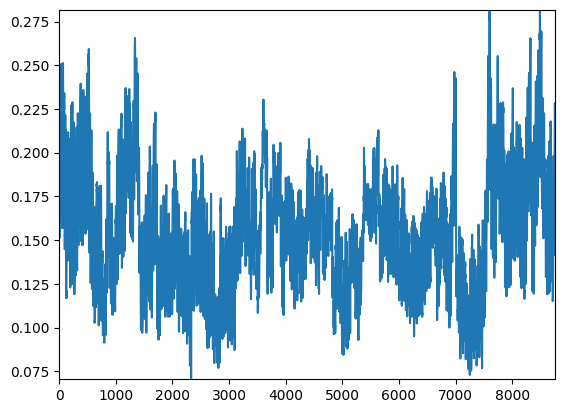

In [18]:
plt.plot(carbon_intensity_data['carbon_intensity'])





/var/folders/0w/_5fcsdzs7bjgmvyjv25_b9l80000gp/T/ipykernel_39567/2038005274.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(month_names)  # Label ticks with month names


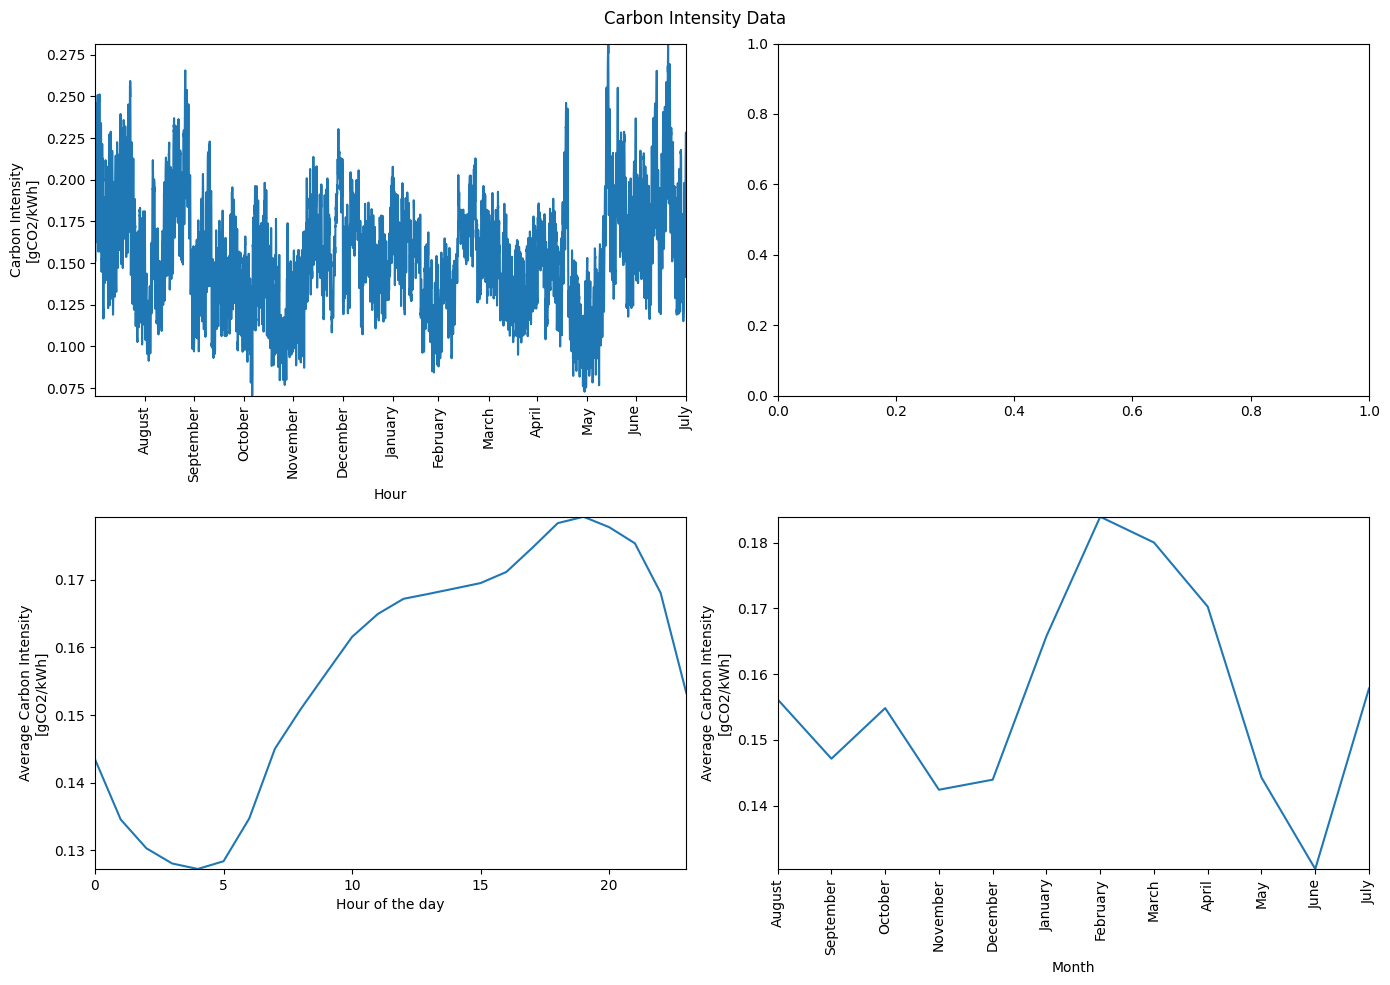

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming carbon_intensity_data is a DataFrame with an index {0, 1, 2, 3, ...}
# Create a DateTimeIndex starting from August 1st at 1 AM
start_date = '2022-08-01 01:00:00'  # Start date and time
carbon_intensity_data.index = pd.date_range(start=start_date, periods=len(carbon_intensity_data), freq='H')

# Extract hour, month, and day from the DateTimeIndex
carbon_intensity_data['hour'] = carbon_intensity_data.index.hour
carbon_intensity_data['month'] = carbon_intensity_data.index.month
carbon_intensity_data['day'] = carbon_intensity_data.index.day

# Aggregating data by hour of the day
hourly_data = carbon_intensity_data.groupby('hour').mean()

# Aggregating data by month
monthly_data = carbon_intensity_data.groupby('month').mean()

# List of month names starting from August
month_names = ['August', 'September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May', 'June', 'July']

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Original plots
x = carbon_intensity_data.index
y1 = carbon_intensity_data['carbon_intensity']  # Assuming the column name is 'carbon_intensity'
axs[0, 0].plot(y1)
axs[0, 0].set_xlabel('Hour')
axs[0, 0].set_ylabel('Carbon Intensity\n[gCO2/kWh]')
# axs[0, 0].set_xticks(range(0, len(carbon_intensity_data), 730))  # Set x-ticks every 730 hours
axs[0, 0].set_xticklabels(month_names)  # Label ticks with month names
plt.setp(axs[0, 0].get_xticklabels(), rotation=90)  # Rotate tick labels by 90 degrees

# Plotting carbon intensity aggregated by hour of the day
axs[1, 0].plot(hourly_data.index, hourly_data['carbon_intensity'])
axs[1, 0].set_xlabel('Hour of the day')
axs[1, 0].set_ylabel('Average Carbon Intensity\n[gCO2/kWh]')

# Plotting carbon intensity aggregated by month
axs[1, 1].plot(monthly_data.index, monthly_data['carbon_intensity'])
axs[1, 1].set_xlabel('Month')
axs[1, 1].set_ylabel('Average Carbon Intensity\n[gCO2/kWh]')
axs[1, 1].set_xticks(monthly_data.index)  # Set x-ticks to month indices
axs[1, 1].set_xticklabels(month_names)  # Label ticks with month names
plt.setp(axs[1, 1].get_xticklabels(), rotation=90)  # Rotate tick labels by 90 degrees

fig.suptitle('Carbon Intensity Data')
plt.tight_layout()

# Save the figure
fig.savefig('carbon_intensity_data_plots.png', dpi=300)

# Show the plot
plt.show()

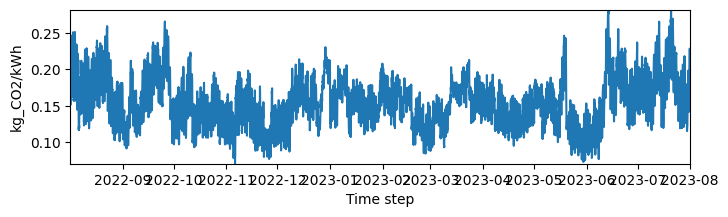

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
x = carbon_intensity_data.index
y = carbon_intensity_data['carbon_intensity']
ax.plot(x, y)
ax.set_xlabel('Time step')
ax.set_ylabel('kg_CO2/kWh')
plt.show()

## Data Preprocessing

Now that we are familiar with the CityLearn `citylearn_challenge_2022_phase_all` dataset, we will assign some constants that make minor changes to its schema that will improve our learning experience in this tutorial. These changes are as follows:

1. We want to use a subset of the buildings so that we are not overwhelmed by the amount of data to analyze during the tutorial 🙂. Since CityLearn is primarily designed for district level energy management and coordination we should use more than one building, although a one-building environment is possible. A considerable building count for tutoring purposes is two to three.
2. We want to use only a one-week period from the entire one-year period for this tutorial for the same reason of ease of analysis.
3. Instead of using the [full observation space](https://www.citylearn.net/overview/observations.html) that will take a while to explore and converge in RL implementations, we will narrow down the space to only one observation: `hour`. This is not the best set up because the hour alone does not explain the state transitions in the environment that the agent is observing, nevertheless, it will help highlight the strengths and weaknesses of different control algorithms.
4. CityLearn allows for three control configurations: single-agent, independent multi-agent, and coordinated multi-agent as earlier discussed. In this tutorial we will make use of the single-agent configuration.

To keep things interesting, the buildings and one-week period will be pseudorandomly selected but for reproducibility, we will set the random generator seed. This seed can be changed to any value to select another pseudorandom set of buildings and time period. We will define two functions to help us make these selections:

In [21]:
def select_buildings(
dataset_name: str, count: int, seed: int, buildings_to_exclude: list[str] = None,
) -> list[str]:
    """Randomly select buildings from CityLearn dataset.

    Parameters
    ----------
    dataset_name: str
        CityLearn dataset to query buildings from.
    count: int
        Number of buildings to set as active in schema.
    seed: int
        Seed for pseudo-random number generator
    buildings_to_exclude: list[str]
        List of buildings to exclude from selection pool.

    Returns
    -------
    buildings: list[str]
        List of selected building names.
    """

    assert 1 <= count <= 15, 'count must be between 1 and 15.'

    # set random seed
    np.random.seed(seed)

    # get all building names
    schema = DataSet.get_schema(dataset_name)
    buildings = list(schema['buildings'].keys())

    # remove buildins 12 and 15 as they have pecularities in their data
    # that are not relevant to this tutorial
    buildings_to_exclude = [] if buildings_to_exclude is None \
        else [b for b in buildings_to_exclude]
    buildings_to_exclude += ['Building_12', 'Building_15']

    for b in buildings_to_exclude:
        buildings.remove(b)

    # randomly select specified number of buildings
    buildings = np.random.choice(buildings, size=count, replace=False).tolist()

    # reorder buildings
    building_ids = [int(b.split('_')[-1]) for b in buildings]
    building_ids = sorted(building_ids)
    buildings = [f'Building_{i}' for i in building_ids]

    return buildings

In [22]:
def select_simulation_period(
    dataset_name: str, count: int, seed: int,
    simulation_periods_to_exclude: list[tuple[int, int]] = None
) -> tuple[int, int]:
    """Randomly select environment simulation start and end time steps
    that cover a specified number of days.

    Parameters
    ----------
    dataset_name: str
        CityLearn dataset to query buildings from.
    count: int
        Number of simulation days.
    seed: int
        Seed for pseudo-random number generator.
    simulation_periods_to_exclude: list[tuple[int, int]]
        List of simulation periods to exclude from selection pool.

    Returns
    -------
    simulation_start_time_step: int
        The first time step in schema time series files to
        be read when constructing the environment.
    simulation_end_time_step: int
        The last time step in schema time series files to
        be read when constructing the environment.
    """

    assert 1 <= count <= 365, 'count must be between 1 and 365.'

    # set random seed
    np.random.seed(seed)

    # use any of the files to determine the total
    # number of available time steps
    schema = DataSet.get_schema(dataset_name)
    filename = schema['buildings'][building_name]['carbon_intensity']
    filepath = os.path.join(root_directory, filename)
    time_steps = pd.read_csv(filepath).shape[0]

    # set candidate simulation start time steps
    # spaced by the number of specified days
    simulation_start_time_step_list = np.arange(0, time_steps, 24*count)

    # exclude period if needed
    if simulation_periods_to_exclude is not None:
        simulation_start_time_step_list_to_exclude = \
            [s for s, e in simulation_periods_to_exclude]
        simulation_start_time_step_list = np.setdiff1d(
            simulation_start_time_step_list,
            simulation_start_time_step_list_to_exclude
        )

    else:
        pass

    # randomly select a simulation start time step
    simulation_start_time_step = np.random.choice(
        simulation_start_time_step_list, size=1
    )[0]
    simulation_end_time_step = simulation_start_time_step + 24*count - 1

    return simulation_start_time_step, simulation_end_time_step

### Setting your Random Seed

Begin by setting a random seed. You can set the seed to any integer including your birth day, month or year. Perhaps a lucky number 😁. Choose wisely because we will use this random seed moving forward 😉.

In [23]:
RANDOM_SEED = 0
print('Random seed:', RANDOM_SEED)

Random seed: 0


### Setting the Buildings, Time Periods and Observations to use in Simulations from the Schema

Now we can pseudo-randomly select buildings and time periods as well as set the active observations and cotrol configureation we will use. We use constants to define them which we will parse to the CityLearn `__init__` contructor function when initializing a new environment.

In [24]:
BUILDING_COUNT = 1
BUILDINGS = select_buildings(
    DATASET_NAME,
    BUILDING_COUNT,
    RANDOM_SEED,
)
print('Selected building:', BUILDINGS)

Selected building: ['Building_2']


In [25]:
DAY_COUNT = 7
SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP = select_simulation_period(
    DATASET_NAME,
    DAY_COUNT,
    RANDOM_SEED
)

print(
    f'Selected {DAY_COUNT}-day simulation period:',
    (SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP)
)

Selected 7-day simulation period: (7392, 7559)


In [29]:
SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP, SIMULATION_START_TIME_STEP- SIMULATION_END_TIME_STEP



(7392, 7559, -167)

In [30]:
EVAL_START_TIME_STEP, EVAL_END_TIME_STEP = SIMULATION_START_TIME_STEP +7*24, SIMULATION_END_TIME_STEP +7*24
EVAL_START_TIME_STEP, EVAL_END_TIME_STEP, EVAL_START_TIME_STEP- EVAL_END_TIME_STEP



(7560, 7727, -167)

In [31]:
ACTIVE_OBSERVATIONS = ['hour', 'day_type', 'month', 'electrical_storage_soc' , 'net_electricity_consumption', 'electricity_pricing' ,'solar_generation']
# ACTIVE_OBSERVATIONS = ['hour', 'electrical_storage_soc']

Lastly, the choice of control configuration is set to define an environment that uses one agent to control many buildings (centralized control configuration):

In [32]:
CENTRAL_AGENT = True

# Initialize a CityLearn Environment
***

We will now initialize an example instance of the CityLearn environment that we will use in this tutorial. To initialize an environment, all that needs to be done is call the `citylearn.citylearn.CityLearnEnv.__init__` method and parse in the custom configurations we previously defined:

In [33]:
env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=SIMULATION_START_TIME_STEP,
    simulation_end_time_step=SIMULATION_END_TIME_STEP,
)

The `env` object has a number of properties and methods that can be learned about in the [docs](https://www.citylearn.net/api/citylearn.citylearn.html#citylearn.citylearn.CityLearnEnv). We will interact with some of its feature to learn about the current state of the environment:

In [34]:
env.observation_names

[['month',
  'day_type',
  'hour',
  'solar_generation',
  'electrical_storage_soc',
  'net_electricity_consumption',
  'electricity_pricing']]

In [35]:
print('Current time step:', env.time_step)
print('environment number of time steps:', env.time_steps)
print('environment uses central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))

Current time step: 0
environment number of time steps: 168
environment uses central agent: True
Number of buildings: 1


The buildings in the environment are objects of the `citylearn.building.Building` class and the class properties and methods are detailed in the [docs](https://www.citylearn.net/api/citylearn.building.html#citylearn.building.Building). We will interact with some of these features:

In [36]:
# electrical storage
print('Electrical storage capacity:', {
    b.name: b.electrical_storage.capacity for b in env.buildings
})
print('Electrical storage nominal power:', {
    b.name: b.electrical_storage.nominal_power for b in env.buildings
})
print('Electrical storage loss_coefficient:', {
    b.name: b.electrical_storage.loss_coefficient for b in env.buildings
})
print('Electrical storage soc:', {
    b.name: b.electrical_storage.soc[b.time_step] for b in env.buildings
})
print('Electrical storage efficiency:', {
    b.name: b.electrical_storage.efficiency for b in env.buildings
})
print('Electrical storage electricity consumption:', {
    b.name: b.electrical_storage.electricity_consumption[b.time_step]
    for b in env.buildings
})
print('Electrical storage capacity loss coefficient:', {
    b.name: b.electrical_storage.capacity_loss_coefficient for b in env.buildings
})
print()
# pv
print('PV nominal power:', {
    b.name: b.pv.nominal_power for b in env.buildings
})
print()
# active observations
print('Active observations:', {b.name: b.active_observations for b in env.buildings})
# active actions
print('Active actions:', {b.name: b.active_actions for b in env.buildings})

Electrical storage capacity: {'Building_2': 6.4}
Electrical storage nominal power: {'Building_2': 5.0}
Electrical storage loss_coefficient: {'Building_2': 0.0}
Electrical storage soc: {'Building_2': 0.0}
Electrical storage efficiency: {'Building_2': 0.9}
Electrical storage electricity consumption: {'Building_2': 0.0}
Electrical storage capacity loss coefficient: {'Building_2': 1e-05}

PV nominal power: {'Building_2': 4.0}

Active observations: {'Building_2': ['month', 'day_type', 'hour', 'solar_generation', 'electrical_storage_soc', 'net_electricity_consumption', 'electricity_pricing']}
Active actions: {'Building_2': ['electrical_storage']}


# Key Performance Indicators for Evaluation
---

We evaluate the control agents' performance using five key performance indicators (KPIs) that are to be minimized: electricity cost, carbon emissions, average daily peak, ramping, and (1 - load factor). Average daily peak, ramping and (1 - load factor) are district-level KPIs that are calculated using the aggregated district-level hourly net electricity consumption (kWh), $E_h^{\textrm{district}}$. Electricity cost, and carbon emissions are building-level KPIs that are calculated using the building-level hourly net electricity consumption (kWh), $E_h^{\textrm{building}}$, and are reported at the grid level as the average of the building-level values.

Electricity cost is defined as the sum of building-level imported electricity cost, $E_h^{\textrm{building}} \times T_h$ (\$), where $T_h$ is the electricity rate at hour $h$.

$$
    \textrm{cost} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \times T_h \right )}
$$

Carbon emissions is the sum of building-level carbon emissions (kg<sub>CO<sub>2</sub>e</sub>), $E_h^{\textrm{building}} \times O_h$, where $O_h$ is the carbon intensity (kg<sub>CO<sub>2</sub>e</sub>/kWh) at hour $h$.

$$
    \textrm{carbon emissions} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \times O_h \right )}
$$

Average daily peak, is defined as the mean of the daily $E_h^{\textrm{district}}$ peak where $d$ is the day index and $n$ is the total number of days.

$$
    \textrm{average daily peak} = \frac{
        {\sum}_{d=0}^{n - 1} {\sum}_{h=0}^{23} {\textrm{max} \left (E_{24d + h}^{\textrm{district}}, \dots, E_{24d + 23}^{\textrm{district}} \right)}
    }{n}
$$

Ramping is defined as the absolute difference of consecutive $E_h^{\textrm{district}}$. It represents the smoothness of the district's load profile where low ramping means there is gradual increase in grid load even after self-generation becomes unavailable in the evening and early morning. High ramping means abrupt change in grid load that may lead to unscheduled strain on grid infrastructure and blackouts as a result of supply deficit.

$$
    \textrm{ramping} = \sum_{h=0}^{n-1}  \lvert E_{h}^{\textrm{district}} - E_{h - 1}^{\textrm{district}} \rvert
$$

Load factor is defined as the average ratio of monthly average and peak $E_{h}^{\textrm{district}}$ where $m$ is the month index, $d$ is the number of days in a month and $n$ is the number of months. Load factor represents the efficiency of electricity consumption and is bounded between 0 (very inefficient) and 1 (highly efficient) thus, the goal is to maximize the load factor or in the same fashion as the other KPIs, minimize (1 - load factor).

$$
    \textrm{1 - load factor}  = \Big(
        \sum_{m=0}^{n - 1} 1 - \frac{
            \left (
                \sum_{h=0}^{d - 1} E_{d \cdot m + h}^{\textrm{district}}
            \right ) \div d
        }{
            \textrm{max} \left (E_{d \cdot m}^{\textrm{district}}, \dots, E_{d \cdot m + d - 1}^{\textrm{district}} \right )
    }\Big) \div n
$$

The KPIs are reported as normalized values with respect to the baseline outcome where the baseline outcome is when buildings are not equipped with batteries i.e., no control. Thus a KPI less than 1.0 is preferred to make a case for including the battery or an advanced control approach.

$$
    \textrm{KPI} = \frac{{\textrm{KPI}_{control}}}{\textrm{KPI}_{baseline (no\ battery)}}
$$

# Convenience Functions to Display Simulation Results
---

CityLearn itself is able to report the key performance indicators (KPIs) during simulation using the `citylearn.citylearn.CityLearnEnv.evaluate` (see [docs](https://www.citylearn.net/api/citylearn.citylearn.html#citylearn.citylearn.CityLearnEnv.evaluate)) method however, let us go ahead and define some convenience functions to help us parse and visualize the KPIs from CityLearn. The first function helps us calculate and return the KPIs in a table:

In [37]:
def get_kpis(env: CityLearnEnv) -> pd.DataFrame:
    """Returns evaluation KPIs.

    Electricity cost and carbon emissions KPIs are provided
    at the building-level and average district-level. Average daily peak,
    ramping and (1 - load factor) KPIs are provided at the district level.

    Parameters
    ----------
    env: CityLearnEnv
        CityLearn environment instance.

    Returns
    -------
    kpis: pd.DataFrame
        KPI table.
    """

    kpis = env.unwrapped.evaluate()

    # names of KPIs to retrieve from evaluate function
    kpi_names = {
        'cost_total': 'Cost',
        'carbon_emissions_total': 'Emissions',
        'daily_peak_average': 'Avg. daily peak',
        'ramping_average': 'Ramping',
        'monthly_one_minus_load_factor_average': '1 - load factor'
    }
    kpis = kpis[
        (kpis['cost_function'].isin(kpi_names))
    ].dropna()
    kpis['cost_function'] = kpis['cost_function'].map(lambda x: kpi_names[x])

    # round up the values to 2 decimal places for readability
    kpis['value'] = kpis['value'].round(2)

    # rename the column that defines the KPIs
    kpis = kpis.rename(columns={'cost_function': 'kpi'})

    return kpis

> ⚠️ **NOTE**:
> You do not need to understand the content of the next code cell where a plotting function is defined.

The next function, `plot_building_kpis` plots the KPIs at the building level in bar charts and can be used to compare different control strategies by providing it with a dictionary that maps a control agent name to the environment the agent acted on:

In [38]:
def plot_building_kpis(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost and carbon emissions
    at the building-level for different control agents in bar charts.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='building'].copy()
        kpis['building_id'] = kpis['name'].str.split('_', expand=True)[1]
        kpis['building_id'] = kpis['building_id'].astype(int).astype(str)
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    kpi_names= kpis['kpi'].unique()
    column_count_limit = 3
    row_count = math.ceil(len(kpi_names)/column_count_limit)
    column_count = min(column_count_limit, len(kpi_names))
    building_count = len(kpis['name'].unique())
    env_count = len(envs)
    figsize = (3.0*column_count, 0.3*env_count*building_count*row_count)
    fig, _ = plt.subplots(
        row_count, column_count, figsize=figsize, sharey=True
    )

    for i, (ax, (k, k_data)) in enumerate(zip(fig.axes, kpis.groupby('kpi'))):
        sns.barplot(x='value', y='name', data=k_data, hue='env_id', ax=ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(k)

        for j, _ in enumerate(envs):
            ax.bar_label(ax.containers[j], fmt='%.2f')

        if i == len(kpi_names) - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

    return fig

> ⚠️ **NOTE**:
> You do not need to understand the content of the next code cell where a plotting function is defined.

The `plot_district_kpis` function plots the KPIs at the district level in a bar chart and can be used to compare different control agents:

In [39]:
def plot_district_kpis(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost, carbon emissions,
    average daily peak, ramping and (1 - load factor) at the
    district-level for different control agents in a bar chart.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='district'].copy()
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    row_count = 1
    column_count = 1
    env_count = len(envs)
    kpi_count = len(kpis['kpi'].unique())
    figsize = (6.0*column_count, 0.225*env_count*kpi_count*row_count)
    fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
    sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    for j, _ in enumerate(envs):
        ax.bar_label(ax.containers[j], fmt='%.2f')

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)
    plt.tight_layout()

    return fig

> ⚠️ **NOTE**:
> You do not need to understand the content of the next code cell where a plotting function is defined.

The `plot_building_load_profiles` function plots the building-level net electricity consumption profiles for the baseline (no battery) and control scenario with battery. It can also be used to compare different control agents:

In [40]:
def plot_building_load_profiles(
    envs: dict[str, CityLearnEnv], daily_average: bool = None
) -> plt.Figure:
    """Plots building-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    daily_average: bool, default: False
        Whether to plot the daily average load profile.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    daily_average = False if daily_average is None else daily_average
    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.75*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            y = v.unwrapped.buildings[i].net_electricity_consumption
            y = np.reshape(y, (-1, 24)).mean(axis=0) if daily_average else y
            x = range(len(y))
            ax.plot(x, y, label=k)

        ax.set_title(v.unwrapped.buildings[i].name)
        ax.set_ylabel('kWh')

        if daily_average:
            ax.set_xlabel('Hour')
            ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

        else:
            ax.set_xlabel('Time step')
            ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig

> ⚠️ **NOTE**:
> You do not need to understand the content of the next code cell where a plotting function is defined.

The `plot_district_load_profiles` function plots the district-level net electricity consumption profiles for the baseline (no battery) and control scenario with battery. It can also be used to compare different control agents.

In [41]:
def plot_district_load_profiles(
    envs: dict[str, CityLearnEnv], daily_average: bool = None
) -> plt.Figure:
    """Plots district-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    daily_average: bool, default: False
        Whether to plot the daily average load profile.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    daily_average = False if daily_average is None else daily_average
    figsize = (5.0, 1.5)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    for k, v in envs.items():
        y = v.unwrapped.net_electricity_consumption
        y = np.reshape(y, (-1, 24)).mean(axis=0) if daily_average else y
        x = range(len(y))
        ax.plot(x, y, label=k)

    ax.set_ylabel('kWh')

    if daily_average:
        ax.set_xlabel('Hour')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

    else:
        ax.set_xlabel('Time step')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

    plt.tight_layout()
    return fig

> ⚠️ **NOTE**:
> You do not need to understand the content of the next code cell where a plotting function is defined.

The `plot_battery_soc_profiles` function plots the building-level battery state of charge (SoC) profiles can also be used to compare different control agents:

In [42]:
def plot_battery_soc_profiles(envs: dict[str, CityLearnEnv]) -> plt.Figure:
    """Plots building-level battery SoC profiles fro different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.75*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            y = np.array(v.unwrapped.buildings[i].electrical_storage.soc)
            x = range(len(y))
            ax.plot(x, y, label=k)

        ax.set_title(v.unwrapped.buildings[i].name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('SoC')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
        ax.set_ylim(0.0, 1.0)

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig

> ⚠️ **NOTE**:
> You do not need to understand the content of the next code cell where a plotting function is defined.

The last function, `plot_simulation_summary` is a convenience function used to plot all figures in one go:

In [52]:
def plot_simulation_summary(envs: dict[str, CityLearnEnv]):
    """Plots KPIs, load and battery SoC profiles for different control agents.

    Parameters
    ----------
    envs: dict[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    """

    print('#'*8 + ' BUILDING-LEVEL ' + '#'*8)
    print('Building-level KPIs:')
    _ = plot_building_kpis(envs)
    plt.show()

    # print('Building-level simulation period load profiles:')
    # _ = plot_building_load_profiles(envs)
    # plt.show()

    # print('Building-level daily-average load profiles:')
    # _ = plot_building_load_profiles(envs, daily_average=True)
    # plt.show()

    # print('Battery SoC profiles:')
    # _ = plot_battery_soc_profiles(envs)
    # plt.show()

    # print('#'*8 + ' DISTRICT-LEVEL ' + '#'*8)
    # print('District-level KPIs:')
    # _ = plot_district_kpis(envs)
    # plt.show()

    # print('District-level simulation period load profiles:')
    # _ = plot_district_load_profiles(envs)
    # plt.show()

    # print('District-level daily-average load profiles:')
    # _ = plot_district_load_profiles(envs, daily_average=True)
    # plt.show()

<a name="experiment-1"></a>

# Experiment 1: Simulate Baseline
---

In this first experiment, you will learn how to set up a CityLearn environment for control, and how to run inference using a baseline control model.

CityLearn includes the `citylearn.agents.base.BaselineAgent` model that steps through the agent without controlling any of the availiable DERs. Thus, it serves as a good reference when quantifying the benefits of the DERs in the environment.

As seen earlier, we begin by initializing the environment:

In [53]:
ACTIVE_OBSERVATIONS = ['hour', 'day_type', 'month', 'electrical_storage_soc' , 'net_electricity_consumption', 'electricity_pricing' ,'solar_generation']
# ACTIVE_OBSERVATIONS = ['hour', 'day_type', 'month', 'electrical_storage_soc', 'electricity_pricing', 'carbon_intensity', 'solar_generation' ]


In [54]:
baseline_env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=SIMULATION_START_TIME_STEP,
    simulation_end_time_step=SIMULATION_END_TIME_STEP,
)

Next, we initialize an instance of `citylearn.agents.base.BaselineAgent`. Initializing the agent only requires that we supply it the just initialized environment:

In [55]:
baseline_model = BaselineAgent(baseline_env)

Then we run inference on this baseline agent by collecting observations from the environment, selecting actions using the collected observations, and finally applying the actions in one control step. Note that since we are using the baseline agent, there are actually no actions being applied and the `actions` variable you see below is an empty list:

In [56]:
# always start by reseting the environment
observations, _ = baseline_env.reset()

# step through the environment until terminal
# state is reached i.e., the control episode ends


building = baseline_env.buildings[0]
storage = building.electrical_storage

i = 1
while not baseline_env.terminated:

    print(storage.soc[building.time_step])

    if i > 8:
      break
    i+=1
    # select actions from the model
    actions = baseline_model.predict(observations)

    # apply selected actions to the environment

    observations, _, _, _, _ = baseline_env.step(actions)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [57]:
ACTIVE_OBSERVATIONS

['hour',
 'day_type',
 'month',
 'electrical_storage_soc',
 'net_electricity_consumption',
 'electricity_pricing',
 'solar_generation']

In [58]:
observations

[[6, 1, 8, 0.69093335, 0.0, -0.07193333, 0.22]]

Use the next code cell to solve the problem:

> ⚠️ **NOTE**:
> Line 26 in the next cell is commented out. Uncomment it if you have completed [Exercise 1](https://colab.research.google.com/drive/10X0l8FqB4P-gwj6tff-qJyGfU9ZcFScZ#scrollTo=D8fho9lwLmwE) otherwise, it will cause an error.

# RBC NO Back up

In [59]:
ACTIVE_OBSERVATIONS

['hour',
 'day_type',
 'month',
 'electrical_storage_soc',
 'net_electricity_consumption',
 'electricity_pricing',
 'solar_generation']

######## BUILDING-LEVEL ########
Building-level KPIs:


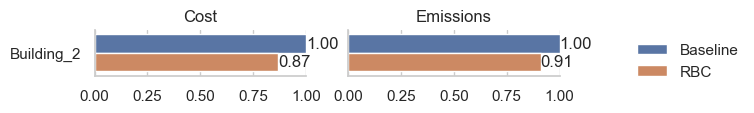

In [65]:
# define action map
soc_values_rbc =  []
net_rbc = []
electricity_price_rbc = []
actions_rbc = []
solar_rbc = []


nbr_back_up_call = 0

back_up = True

action_map = {
    1: 0.0,
    2: 0.0,
    3: 0.0,
    4: 0.0,
    5: 0.0,
    6: 0.0,
    7: 0.0,
    8: 0.10,
    9: 0.10,
    10: 0.10,
    11: 0.10,
    12: 0.10,
    13: 0.15,
    14: 0.15,
    15: 0.15,
    16: 0.05,
    17: 0.0,
    18: -0.10,
    19: -0.20,
    20: -0.20,
    21: -0.10,
    22: -0.10,
    23: -0.10,
    24: -0.10,
}



# # run inference
# rbc_env = CityLearnEnv(
#     DATASET_NAME,
#     central_agent=CENTRAL_AGENT,
#     buildings=BUILDINGS,
#     active_observations=ACTIVE_OBSERVATIONS,
#     simulation_start_time_step=SIMULATION_START_TIME_STEP,
#     simulation_end_time_step=SIMULATION_END_TIME_STEP,
# )


rbc_env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=EVAL_START_TIME_STEP,
    simulation_end_time_step=EVAL_END_TIME_STEP,
)


rbc_model = HourRBC(rbc_env, action_map=action_map)
observations, _ = rbc_env.reset()

building = rbc_env.buildings[0]
storage = building.electrical_storage




i=0

while not rbc_env.terminated:


    actions = rbc_model.predict(observations)



    ## Discretizing the actionss


    # if actions[0][0] > 0.3:
    #   actions = [[0.3]]

    # elif actions[0][0] < -0.3:
    #   actions = [[-0.3]]

    # elif actions[0][0] > 0.05:
    #   actions = [[0.15]]

    # elif actions[0][0] < -0.05:
    #   actions = [[-0.15]]

    # elif 0.0 <actions[0][0] < 0.05:
    #   actions = [[0.0]]

    # elif -0.05 <actions[0][0] < 0.0:
    #   actions = [[0.0]]
       




    if back_up:

      soc_current = storage.soc[building.time_step]
      if soc_current  > 0.90 :
        nbr_back_up_call +=1
        actions = [[-0.10]]

      elif soc_current < 0.10:
        nbr_back_up_call +=1
        actions = [[0.10]]


    




    observations, _, _, _, _ = rbc_env.step(actions)


    net_rbc.append(observations[0][-2])
    electricity_price_rbc.append(observations[0][-1])
    solar_rbc.append(observations[0][3])





    time_step = rbc_env.buildings[0].electrical_storage.time_step
    soc = rbc_env.buildings[0].electrical_storage.soc[storage.time_step]




    soc_values_rbc.append(soc)
    actions_rbc.append(actions[0][0])

    # if i >=2:
    #   break

    i+=1

    # break

# display simulation summary
plot_simulation_summary({
    'Baseline': baseline_env,
    # Uncomment line below if you have completed Exercise 1
    # 'Random': random_env,
    'RBC': rbc_env,
})

In [66]:
rbc_env.buildings

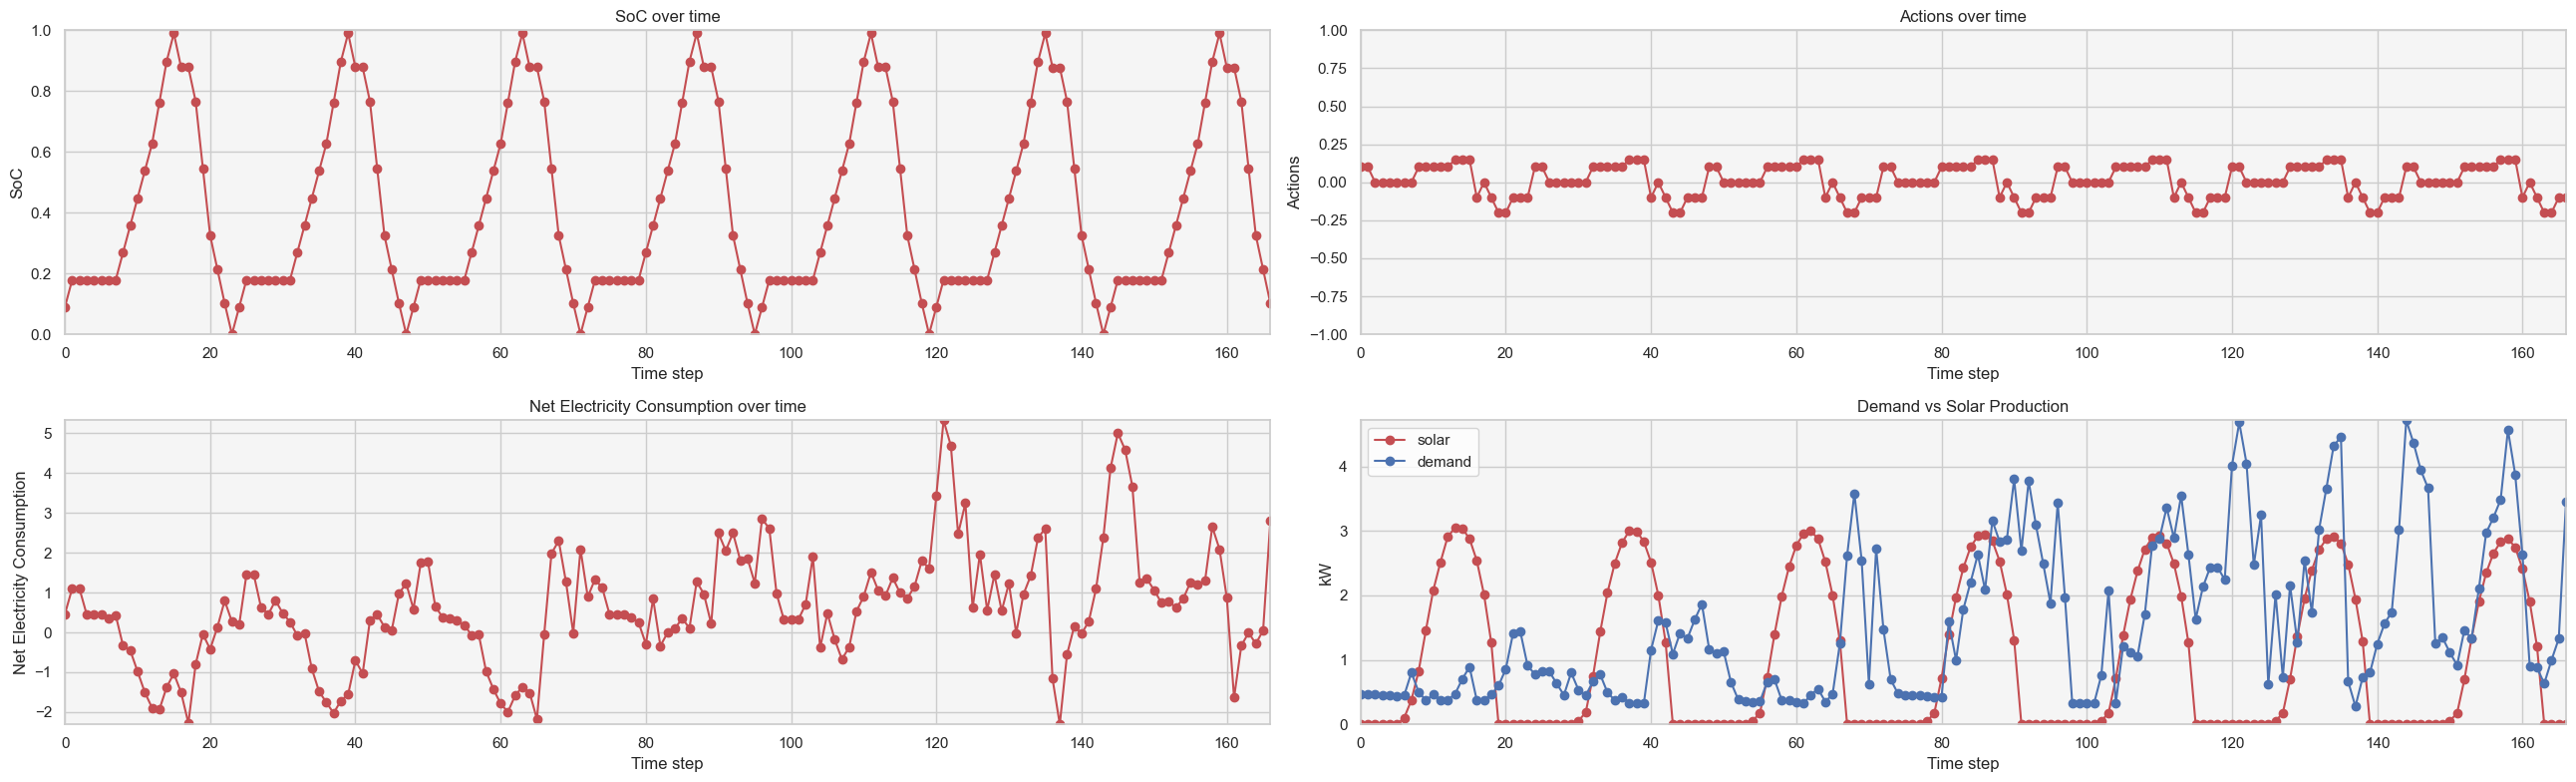

       Metric  Count
0  SoC < 0.10     13
1  SoC > 0.90      7
Number of Back up calls: 21


In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Set Seaborn style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(26, 8))

soc_values_rbc = np.array(soc_values_rbc)
actions_rbc = np.array(actions_rbc)

# Plot SoC values
axes[0][0].plot(soc_values_rbc, marker='o', linestyle='-', color='r')
axes[0][0].set_xlabel('Time step')
axes[0][0].set_ylabel('SoC')
axes[0][0].set_ylim((0, 1))
axes[0][0].set_title('SoC over time')

# Plot Actions
axes[0][1].plot(actions_rbc, marker='o', linestyle='-', color='r')
axes[0][1].set_xlabel('Time step')
axes[0][1].set_ylabel('Actions')
axes[0][1].set_ylim((-1, 1))
axes[0][1].set_title('Actions over time')


# Plot Actions
axes[1][0].plot(rbc_env.buildings[0].net_electricity_consumption[:-1], marker='o', linestyle='-', color='r')
# axes[1][0].plot(net_rbc, marker='o', linestyle='-', color='r')
# axes[1][0].plot(building_data[7392: 7559]['non_shiftable_load'], marker='o', linestyle='-', color='r')
axes[1][0].set_xlabel('Time step')
axes[1][0].set_ylabel('Net Electricity Consumption')
# axes[1][0].set_ylim((-1, 1))
axes[1][0].set_title('Net Electricity Consumption over time')


# Plot Actions
axes[1][1].plot(-1*rbc_env.buildings[0].solar_generation[:-1], marker='o', linestyle='-', color='r', label = 'solar')
axes[1][1].plot(rbc_env.buildings[0].non_shiftable_load[:-1], marker='o', linestyle='-', color='b', label = 'demand')
axes[1][1].legend()
axes[1][1].set_xlabel('Time step')
axes[1][1].set_ylabel('kW')
# axes[1][1].set_ylim((-1, 1))
axes[1][1].set_title('Demand vs Solar Production')



# Enhance plot aesthetics
for ax in axes:
    ax[0].grid(True)
    ax[0].set_facecolor('whitesmoke')

    ax[1].grid(True)
    ax[1].set_facecolor('whitesmoke')

# Display the plots
plt.tight_layout()
plt.show()

# Create DataFrame for statistics
data = {
    'Metric': ['SoC < 0.10', 'SoC > 0.90'],
    'Count': [np.sum(soc_values_rbc < .10), np.sum(soc_values_rbc > .90)]
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)
print('Number of Back up calls:', nbr_back_up_call)

latex_code = df.to_latex(index=False)
# print(latex_code)

The current reward functions is the electricity consumption from the grid at the current time step returned as a negative value. While this reward will penalize high electricity consumption, it might not be ideal for all KPIs we are trying to optimize. As you would imagine, the best way to minimize electricity consumption is to try to move all loads to the battery hence, the insistence of the agent to continue to discharge the batteries!

## Defining a Custom Reward Function

We want to reduce electricity cost and emissions. Likewise, we want to reduce the peaks and ramping, and increase the load factor. One way to achieve this is to teach the agent to charge the batteries when electricity is cheap after 9 PM and before 4 PM, which typically coincides with when the grid is cleaner (lower emissions). But recall that each building is able to generate power provided there is solar radiation. So, we can take advantage of self-generation in the late morning to late afternoon to charge for free and discharge the rest of the day thus, reducing electricity cost and emissions at the very least. Also, by shifting the early morning and evening peak loads to the batteries we can improve on our peak and load-factor KPIs.

We should also teach our agent to ensure that renewable solar generation is not wasted by making use of the PV to charge the batteries while they are charged below capacity. On the flip side, the agent should learn to discharge when there is net positive grid load and the batteries still have stored energy.

Given these learning objectives, we can now define a reward function that closely satisfies the criteria for which the agent will learn good rewards:

$$
    r = \sum_{i=0}^n \Big(p_i \times |C_i|\Big)
$$

$$
    p_i = -\left(1 + \textrm{sign}(C_i) \times \textrm{SoC}^{\textrm{battery}}_i\right)
$$

The reward function, $r$, is designed to minimize electricity cost, $C$. It is calculated for each building, $i$ and summed to provide the agent with a reward that is representative of all $n$ buildings. It encourages net-zero energy use by penalizing grid load satisfaction when there is energy in the battery as well as penalizing net export when the battery is not fully charged through the penalty term, $p$. There is neither penalty nor reward when the battery is fully charged during net export to the grid. Whereas, when the battery is charged to capacity and there is net import from the grid the penalty is maximized.

Now we define this custom reward using the instructions provided in the [docs](https://www.citylearn.net/overview/reward_function.html#how-to-define-a-custom-reward-function) below and set it as the reward for the SAC agent.

In [68]:
from typing import Any, Dict, List, Union

class CustomReward(RewardFunction):
    def __init__(self, env_metadata: Dict[str, Any]):
        r"""Initialize CustomReward.

        Parameters
        ----------
        env_metadata: dict[str, Any]:
            General static information about the environment.
        """
        super().__init__(env_metadata)

    def calculate(
        self, observations: List[Dict[str, Union[int, float]]]
    ) -> List[float]:
        r"""Returns reward for most recent action.

        The reward is designed to minimize electricity cost.
        It is calculated for each building, i and summed to provide the agent
        with a reward that is representative of all n buildings.
        It encourages net-zero energy use by penalizing grid load satisfaction
        when there is energy in the battery as well as penalizing
        net export when the battery is not fully charged through the penalty
        term. There is neither penalty nor reward when the battery
        is fully charged during net export to the grid. Whereas, when the
        battery is charged to capacity and there is net import from the
        grid the penalty is maximized.

        Parameters
        ----------
        observations: list[dict[str, int | float]]
            List of all building observations at current
            :py:attr:`citylearn.citylearn.CityLearnEnv.time_step`
            that are got from calling
            :py:meth:`citylearn.building.Building.observations`.

        Returns
        -------
        reward: list[float]
            Reward for transition to current timestep.
        """
    



        reward_list = []

        for o, m in zip(observations, self.env_metadata['buildings']):
            




            
            cost = o['net_electricity_consumption']*o['electricity_pricing']
            battery_soc = o['electrical_storage_soc']
            penalty = -(1.0 + np.sign(cost)*battery_soc)
            reward = penalty*abs(cost)


            
            # Penalty for breaking constraints

            if battery_soc > .90:
                reward = reward - 75*(battery_soc - 0.90)**2
            elif battery_soc < .10:
                reward = reward - 75*(0.10 - battery_soc)**2




            reward_list.append(reward)

        reward = [sum(reward_list)]

        
        return reward

Let us repeat all the previous steps we took in the former SAC simulation where the only difference in the workflow here is the use of our new custom reward function:

In [69]:
ACTIVE_OBSERVATIONS

['hour',
 'day_type',
 'month',
 'electrical_storage_soc',
 'net_electricity_consumption',
 'electricity_pricing',
 'solar_generation']

In [70]:
SIMULATION_START_TIME_STEP, SIMULATION_END_TIME_STEP

(7392, 7559)

In [72]:
EVAL_START_TIME_STEP, EVAL_END_TIME_STEP

(7560, 7727)

In [73]:
import time
from tqdm import tqdm

In [80]:
sacr_env = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=EVAL_START_TIME_STEP,
    simulation_end_time_step=EVAL_END_TIME_STEP,
    reward_function=CustomReward, # assign custom reward function
)
sacr_env = NormalizedObservationWrapper(sacr_env)
# sacr_env = DiscreteActionWrapper(sacr_env)
sacr_env = StableBaselines3Wrapper(sacr_env)

sacr_model = SAC(policy='MlpPolicy', env=sacr_env, seed=RANDOM_SEED)
# sacr_model = PPO(policy='MlpPolicy', env=sacr_env, seed=RANDOM_SEED)
# sacr_model = DDPG(policy='MlpPolicy', env=sacr_env, seed=RANDOM_SEED)
# sacr_model = A2C(policy='MlpPolicy', env=sacr_env, seed=RANDOM_SEED)

sacr_episode_timesteps = sacr_env.unwrapped.time_steps - 1

start_time = time.time()

for i in tqdm(range(2_00)):
    sacr_model = sacr_model.learn(
        total_timesteps=sacr_episode_timesteps,
        reset_num_timesteps=False,
    )

# End timing
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken for training: {elapsed_time:.2f} seconds")

100%|██████████| 200/200 [21:19<00:00,  6.40s/it]

Time taken for training: 1279.04 seconds


Finally, evaluate the trained model:

> ⚠️ **NOTE**:
> Line 12 in the next cell is commented out. Uncomment it if you have completed [Exercise 1](https://colab.research.google.com/drive/10X0l8FqB4P-gwj6tff-qJyGfU9ZcFScZ#scrollTo=D8fho9lwLmwE) otherwise, it will cause an error.

# SAC With BACK UP

In [81]:
#Evaluating on a differnt time sequences


sacr_env_eval = CityLearnEnv(
    DATASET_NAME,
    central_agent=CENTRAL_AGENT,
    buildings=BUILDINGS,
    active_observations=ACTIVE_OBSERVATIONS,
    simulation_start_time_step=EVAL_START_TIME_STEP,
    simulation_end_time_step=EVAL_END_TIME_STEP,
    reward_function=CustomReward, # assign custom reward function
)
sacr_env_eval = NormalizedObservationWrapper(sacr_env_eval)
# sacr_env = DiscreteActionWrapper(sacr_env)
sacr_env_eval = StableBaselines3Wrapper(sacr_env_eval)

/Users/leobenac/Desktop/Derms/CityLearn/dermsvenv/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.buildings to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.buildings` for environment variables or `env.get_wrapper_attr('buildings')` that will search the reminding wrappers.
  logger.warn(


######## BUILDING-LEVEL ########
Building-level KPIs:


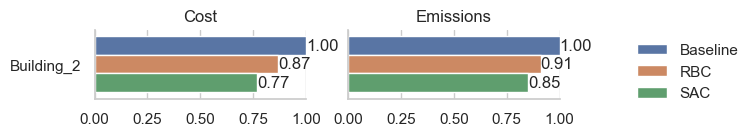

In [82]:
observations, _ = sacr_env_eval.reset()

sac_actions = []
soc_values_sac = []
# sac_plus_actions = []


back_up = True
nbr_back_up_call_sac = 0



# assert (back_up == True) or (back_up_smooth == True)

building = sacr_env_eval.buildings[0]
storage = building.electrical_storage

while not sacr_env_eval.unwrapped.terminated:


    actions, _ = sacr_model.predict(observations, deterministic=True)
    soc_current = storage.soc[building.time_step]


    ## Discretizing the actionss

    # if actions[0] > 0.3:
    #   actions = [0.3]

    # elif actions[0] < -0.3:
    #   actions = [-0.3]

    # elif actions[0] > 0.05:
    #   actions = [0.15]

    # elif actions[0] < -0.05:
    #   actions = [-0.15]

    # elif 0.0 <actions[0] < 0.05:
    #   actions = [0.0]

    # elif -0.05 <actions[0] < 0.0:
    #   actions = [0.0]
       


    if back_up:

        soc_current = storage.soc[building.time_step]
        if soc_current  > 0.90 :
          nbr_back_up_call_sac +=1
          actions = [-0.10]

        elif soc_current < 0.10:
          nbr_back_up_call_sac +=1
          actions = [0.10]


    action = actions[0]



    observations, _, _, _, _ = sacr_env_eval.step(actions)
    sac_actions.append(action)
    soc_values_sac.append(soc_current)




# plot summary and compare with other control results

plot_simulation_summary({
    'Baseline': baseline_env,
    # Uncomment line below if you have completed Exercise 1
    # 'Random': random_env,
    # 'RBC': rbc_env,
    # 'TQL': tql_env,
    # 'SAC-1': sac_env,
    'RBC': rbc_env,
    'SAC': sacr_env_eval
})

soc_values_sac = np.array(soc_values_sac)

# NO BACK UP

/Users/leobenac/Desktop/Derms/CityLearn/dermsvenv/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.buildings to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.buildings` for environment variables or `env.get_wrapper_attr('buildings')` that will search the reminding wrappers.
  logger.warn(


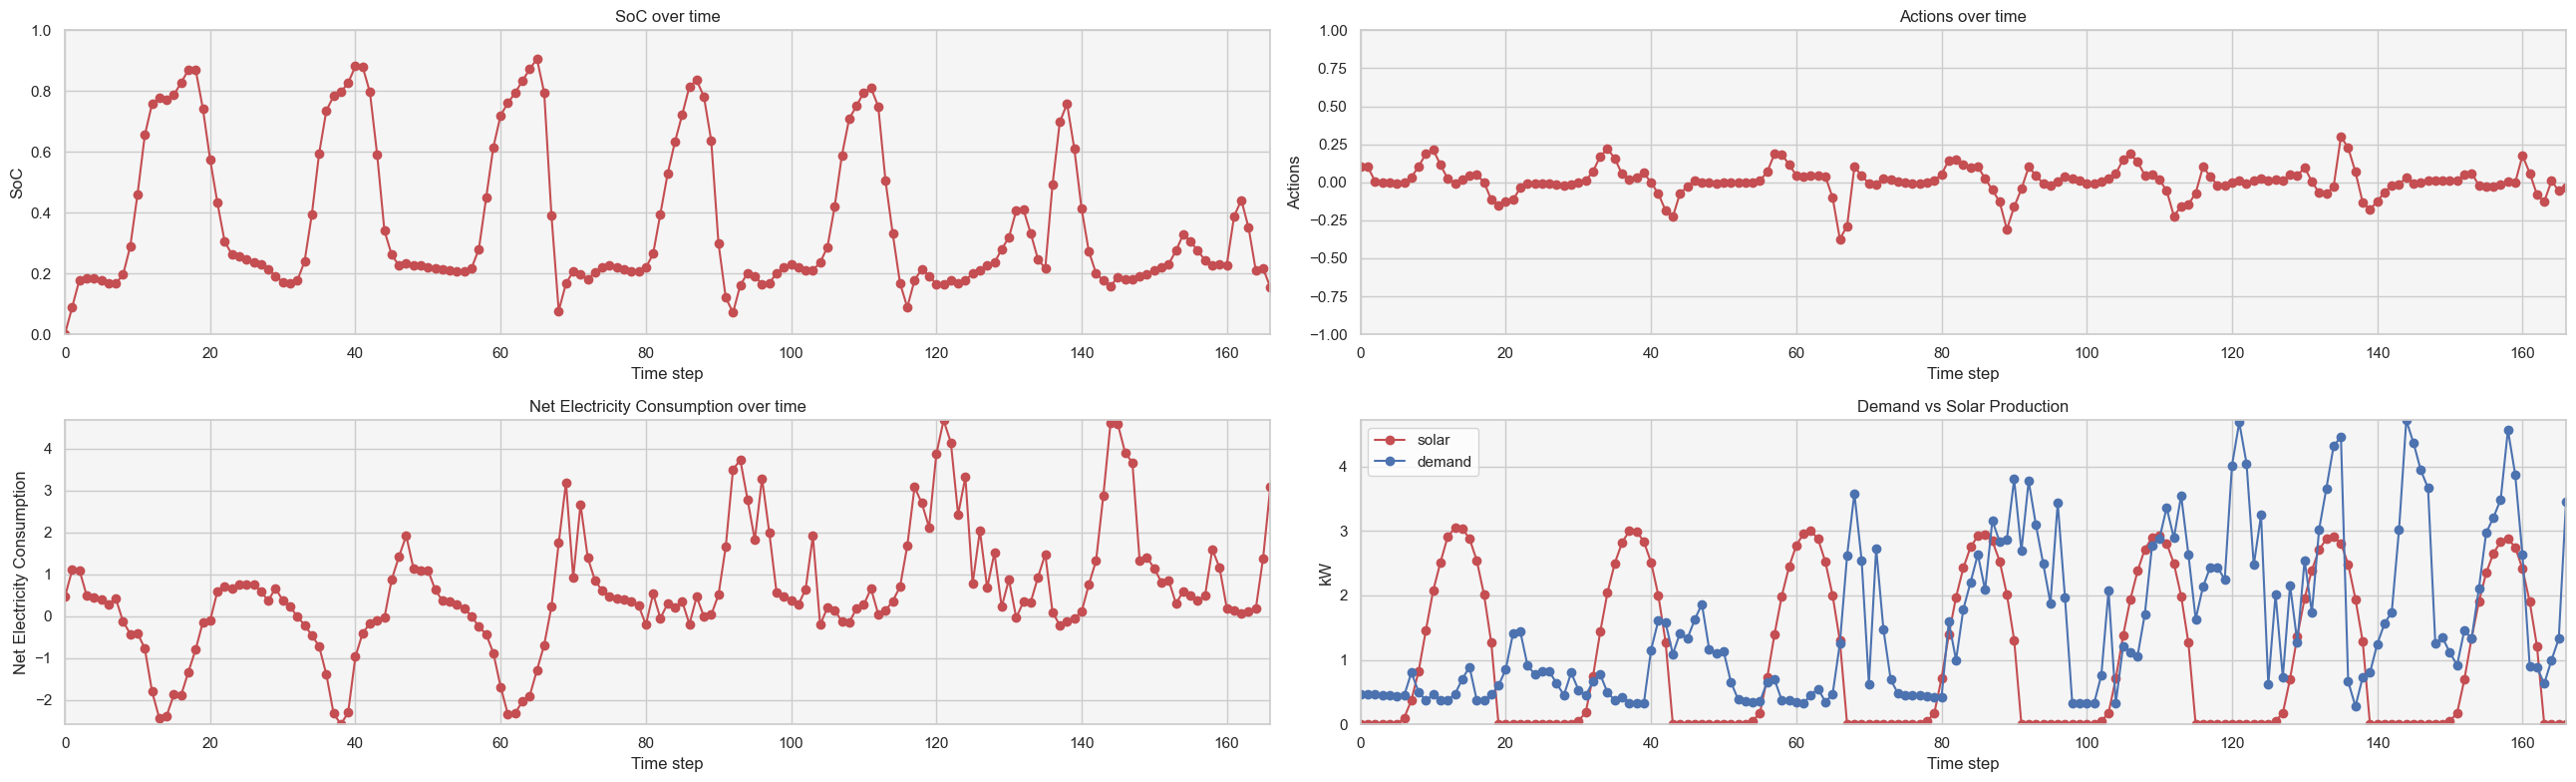

       Metric  Count
0  SoC < 0.10      5
1  SoC > 0.90      1
Number of Back up calls: 6


In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Set Seaborn style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(26, 8))

soc_values_rbc = np.array(soc_values_rbc)
actions_rbc = np.array(actions_rbc)

# Plot SoC values
axes[0][0].plot(soc_values_sac, marker='o', linestyle='-', color='r')
axes[0][0].set_xlabel('Time step')
axes[0][0].set_ylabel('SoC')
axes[0][0].set_ylim((0, 1))
axes[0][0].set_title('SoC over time')

# Plot Actions
axes[0][1].plot(sac_actions, marker='o', linestyle='-', color='r')
axes[0][1].set_xlabel('Time step')
axes[0][1].set_ylabel('Actions')
axes[0][1].set_ylim((-1, 1))
axes[0][1].set_title('Actions over time')


# Plot Actions
axes[1][0].plot(sacr_env_eval.buildings[0].net_electricity_consumption[:-1], marker='o', linestyle='-', color='r')
# axes[1][0].plot(net_rbc, marker='o', linestyle='-', color='r')
# axes[1][0].plot(building_data[7392: 7559]['non_shiftable_load'], marker='o', linestyle='-', color='r')
axes[1][0].set_xlabel('Time step')
axes[1][0].set_ylabel('Net Electricity Consumption')
# axes[1][0].set_ylim((-1, 1))
axes[1][0].set_title('Net Electricity Consumption over time')


# Plot Actions
axes[1][1].plot(-1*sacr_env_eval.buildings[0].solar_generation[:-1], marker='o', linestyle='-', color='r', label = 'solar')
axes[1][1].plot(sacr_env_eval.buildings[0].non_shiftable_load[:-1], marker='o', linestyle='-', color='b', label = 'demand')
axes[1][1].legend()
axes[1][1].set_xlabel('Time step')
axes[1][1].set_ylabel('kW')
# axes[1][1].set_ylim((-1, 1))
axes[1][1].set_title('Demand vs Solar Production')



# Enhance plot aesthetics
for ax in axes:
    ax[0].grid(True)
    ax[0].set_facecolor('whitesmoke')

    ax[1].grid(True)
    ax[1].set_facecolor('whitesmoke')

# Display the plots
plt.tight_layout()
plt.show()

# Create DataFrame for statistics
data = {
    'Metric': ['SoC < 0.10', 'SoC > 0.90'],
    'Count': [np.sum(np.array(soc_values_sac) < .10), np.sum(np.array(soc_values_sac) > .90)]
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)
print('Number of Back up calls:', nbr_back_up_call_sac)

latex_code = df.to_latex(index=False)
# print(latex_code)

# SAC BACK UP SMOOTH

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.buildings to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.buildings` for environment variables or `env.get_wrapper_attr('buildings')` that will search the reminding wrappers.
  logger.warn(


######## BUILDING-LEVEL ########
Building-level KPIs:


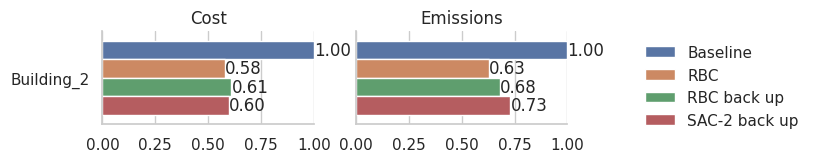

Building-level simulation period load profiles:


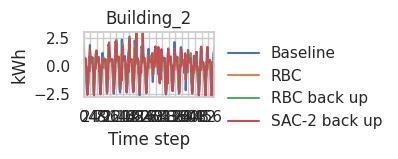

Building-level daily-average load profiles:


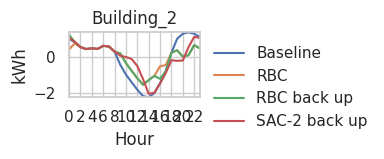

Battery SoC profiles:


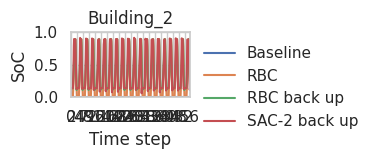

######## DISTRICT-LEVEL ########
District-level KPIs:


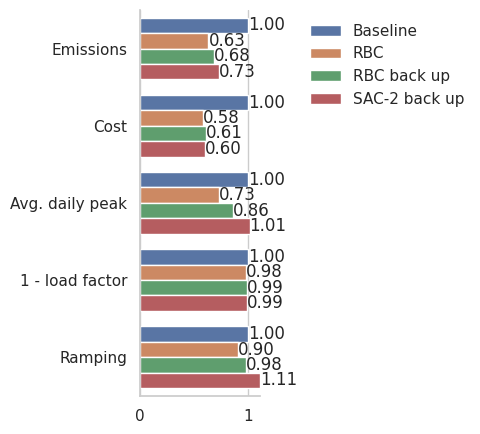

District-level simulation period load profiles:


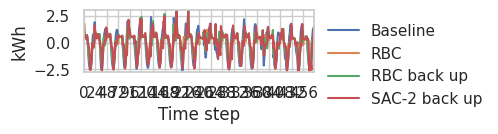

District-level daily-average load profiles:


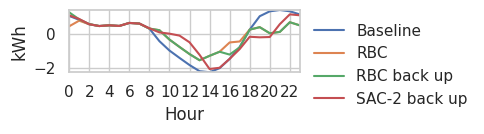

In [ ]:
observations, _ = sacr_env.reset()

sac_actions = []
soc_values_sac = []
# sac_plus_actions = []


# back_up = False

back_up_smooth = True

# assert (back_up == True) or (back_up_smooth == True)

building = sacr_env.buildings[0]
storage = building.electrical_storage

while not sacr_env.unwrapped.terminated:


    actions, _ = sacr_model.predict(observations, deterministic=True)

    action = actions[0]



    soc_current = storage.soc[building.time_step]


    # sac_plus_actions.append(soc_current + (action))

    if back_up:
      if soc_current + (actions[0]) <= 0.12:
          actions[0] = 0.1
      if soc_current + (actions[0]) >= 0.90:
          actions[0] = -0.1



    if back_up_smooth:
      if soc_current + action * storage.efficiency > 0.89:
        # print(soc_current, action)
        action = (0.89 - soc_current)/ storage.efficiency
        actions = np.array([action])

      elif soc_current + action * storage.efficiency < 0.14:
        # print(soc_current, action)
        action = (0.14 - soc_current)/ storage.efficiency
        actions = np.array([action])





    observations, _, _, _, _ = sacr_env.step(actions)
    sac_actions.append(action)
    soc_values_sac.append(soc_current)




# plot summary and compare with other control results

plot_simulation_summary({
    'Baseline': baseline_env,
    # Uncomment line below if you have completed Exercise 1
    # 'Random': random_env,
    'RBC': rbc_env,
    # 'TQL': tql_env,
    # 'SAC-1': sac_env,
    'RBC back up': rbc_env_back_up,
    'SAC-2 back up': sacr_env
})

soc_values_sac = np.array(soc_values_sac)

# BACK UP SMOOTH

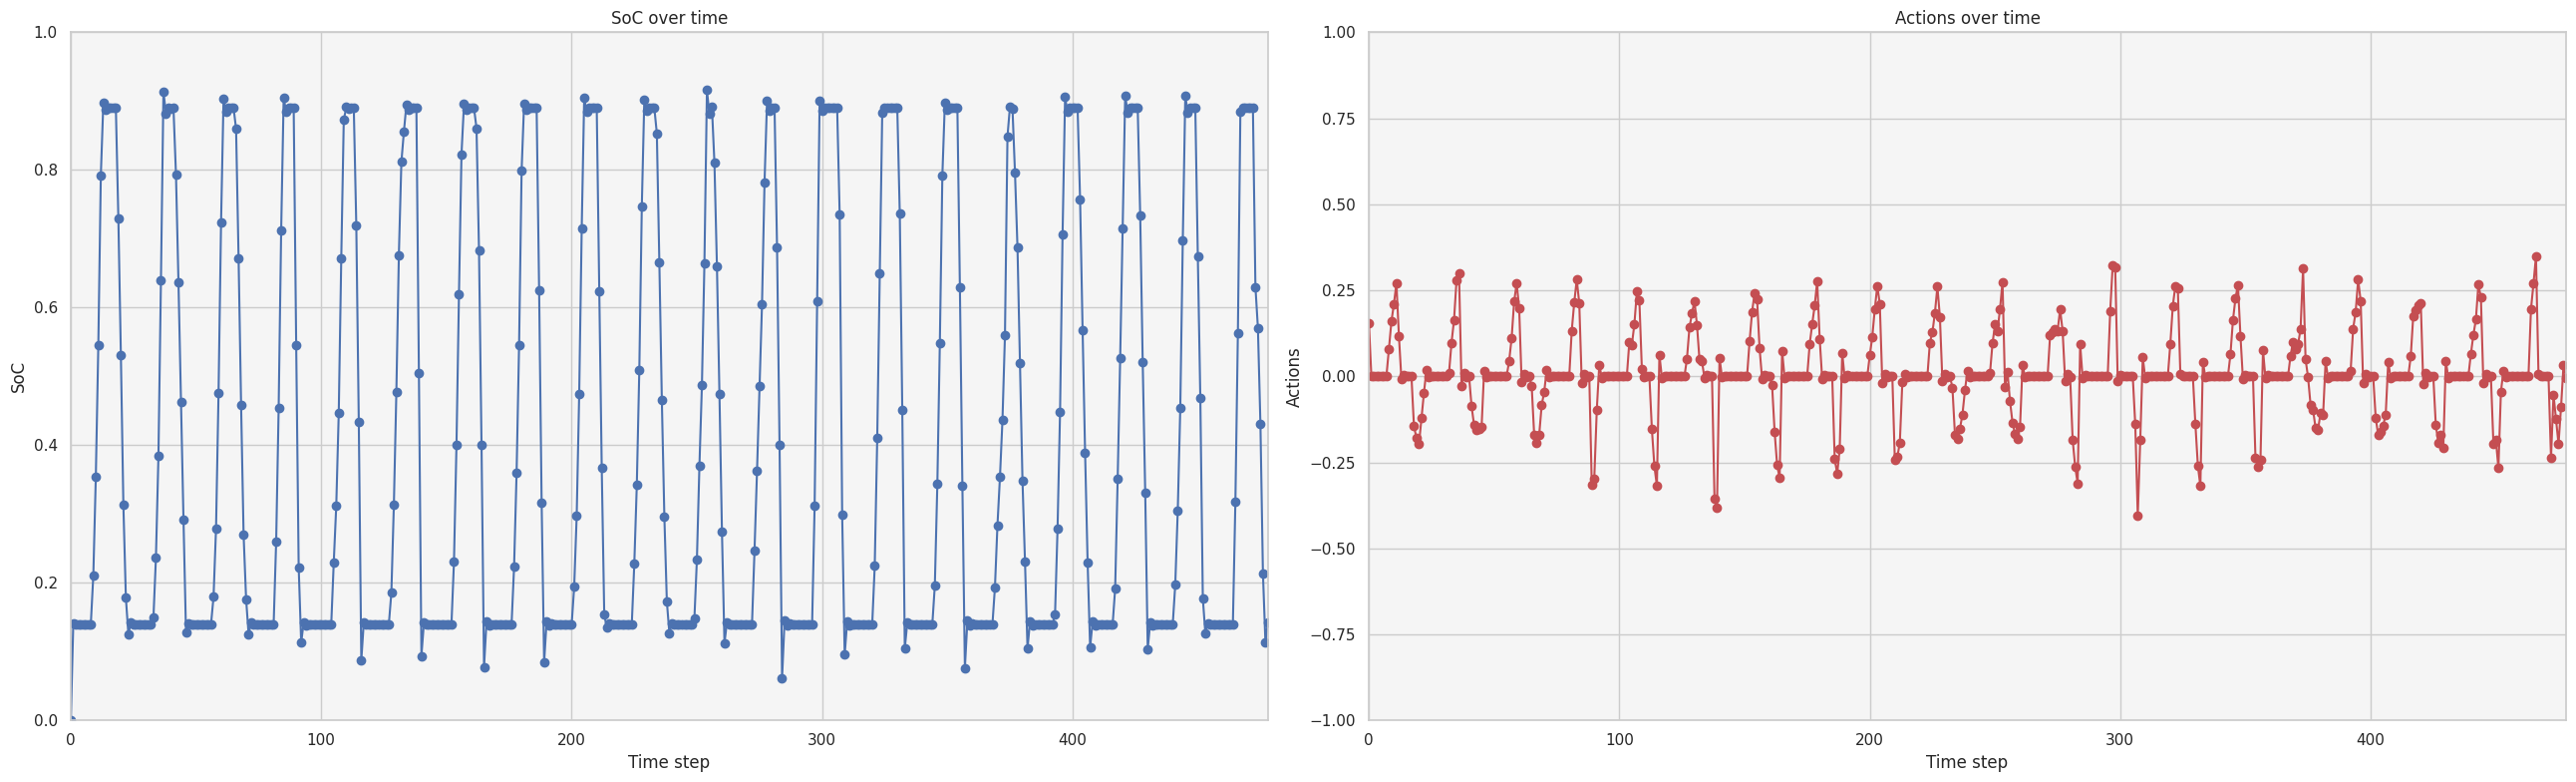

       Metric  Count
0  SoC < 0.10      8
1  SoC > 0.90     11
\begin{tabular}{lr}
\toprule
Metric & Count \\
\midrule
SoC < 0.10 & 8 \\
SoC > 0.90 & 11 \\
\bottomrule
\end{tabular}



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Set Seaborn style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(26, 8))


# Plot SoC values
axes[0].plot(soc_values_sac, marker='o', linestyle='-', color='b')
axes[0].set_xlabel('Time step')
axes[0].set_ylabel('SoC')
axes[0].set_ylim((0, 1))
axes[0].set_title('SoC over time')

# Plot Actions
axes[1].plot(sac_actions, marker='o', linestyle='-', color='r')
axes[1].set_xlabel('Time step')
axes[1].set_ylabel('Actions')
axes[1].set_ylim((-1, 1))
axes[1].set_title('Actions over time')

# Enhance plot aesthetics
for ax in axes:
    ax.grid(True)
    ax.set_facecolor('whitesmoke')

# Display the plots
plt.tight_layout()
plt.show()

# Create DataFrame for statistics
data = {
    'Metric': ['SoC < 0.10', 'SoC > 0.90'],
    'Count': [np.sum(soc_values_sac < .10), np.sum(soc_values_sac > .90)]
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

latex_code = df.to_latex(index=False)
print(latex_code)

# SMOOTH BACK UP

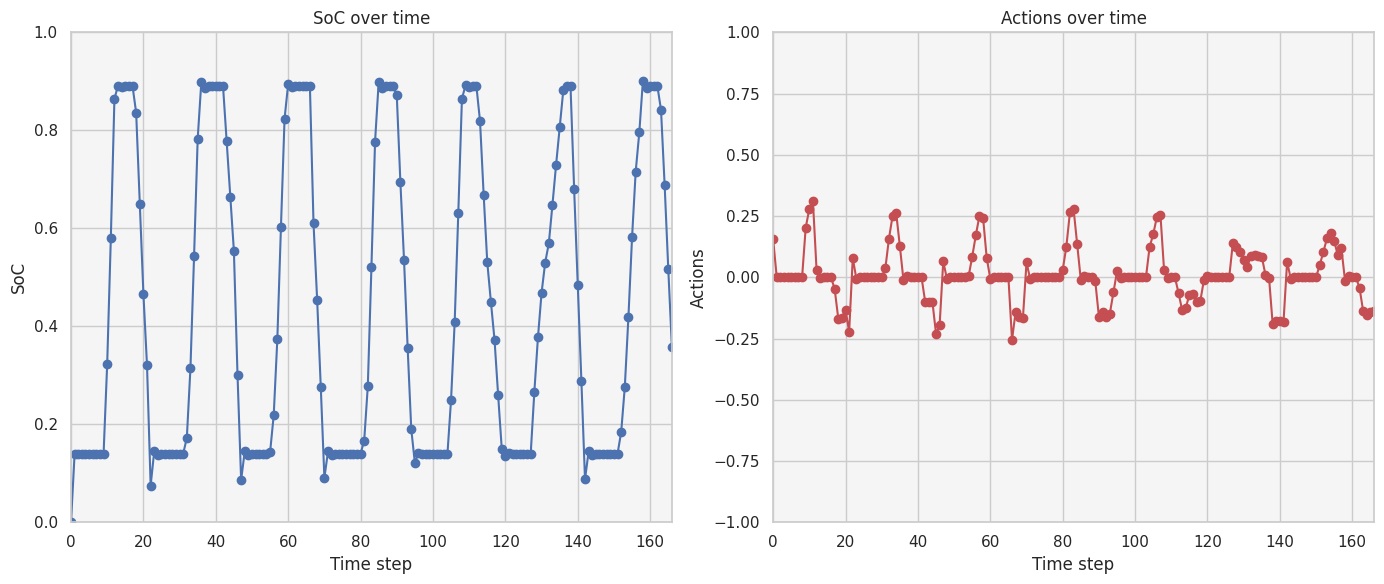

       Metric  Count
0  SoC < 0.10      5
1  SoC > 0.90      1
\begin{tabular}{lr}
\toprule
Metric & Count \\
\midrule
SoC < 0.10 & 5 \\
SoC > 0.90 & 1 \\
\bottomrule
\end{tabular}



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Set Seaborn style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))


# Plot SoC values
axes[0].plot(soc_values_sac, marker='o', linestyle='-', color='b')
axes[0].set_xlabel('Time step')
axes[0].set_ylabel('SoC')
axes[0].set_ylim((0, 1))
axes[0].set_title('SoC over time')

# Plot Actions
axes[1].plot(sac_actions, marker='o', linestyle='-', color='r')
axes[1].set_xlabel('Time step')
axes[1].set_ylabel('Actions')
axes[1].set_ylim((-1, 1))
axes[1].set_title('Actions over time')

# Enhance plot aesthetics
for ax in axes:
    ax.grid(True)
    ax.set_facecolor('whitesmoke')

# Display the plots
plt.tight_layout()
plt.show()

# Create DataFrame for statistics
data = {
    'Metric': ['SoC < 0.10', 'SoC > 0.90'],
    'Count': [np.sum(soc_values_sac < .10), np.sum(soc_values_sac > .90)]
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

latex_code = df.to_latex(index=False)
print(latex_code)

Finally, we have results that have improved the baseline KPIs all thanks to our custom reward function! The agent has learned to take advantage of the solar generation to charge the batteries and discharge the stored energy during the evening peak.

Let us now have a look at the actions that the agent predicted in the deterministic simulation:

In [ ]:
fig = plot_actions(sacr_actions_list, BUILDINGS, 'SAC Actions using Custom Reward')
plt.show()

The agent learned the different building needs as building 7 begins to charge later than building 2 daily (selected buildings when `RANDOM_SEED` = 0). The agent discharges the batteries differently as well.

## Evaluate the Episode Rewards for RL Algorithms

We can also investigate the convergence rate in training by looking at the sum of rewards in each episode. We expect to see the reward sum increase as we train on more episodes and eventually plateau when exploitation increases or performance can not be further improved. We will look at the reward trajectory for the Tabular Q-Learning, SAC with and without custom reward models:

In [ ]:
def plot_rewards(ax: plt.Axes, rewards: list[float], title: str) -> plt.Axes:
    """Plots rewards over training episodes.

    Parameters
    ----------
    rewards: list[float]
        List of reward sum per episode.
    title: str
        Plot axes title

    Returns
    -------
    ax: plt.Axes
        Plotted axes
    """

    ax.plot(rewards)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title(title)

    return ax

In [ ]:
envs = {
    # 'Tabular Q-Learning': pd.DataFrame(tql_env.unwrapped.episode_rewards)['sum'].tolist(),
    # 'SAC-1': pd.DataFrame(sac_env.unwrapped.episode_rewards)['sum'].tolist(),
    'SAC-2': pd.DataFrame(sacr_env.unwrapped.episode_rewards)['sum'].tolist()
}
fig, axs = plt.subplots(1, 3, figsize=(12, 2))

for ax, (k, v) in zip(fig.axes, envs.items()):
    ax = plot_rewards(ax, v, k)

plt.tight_layout()
plt.show()

Some questions to ponder on:
1. What do you notice in the reward trajectories for the three models?
2. Which model converged?
3. Which model did not learn anything?
4. Which model needs to train some more?

<a name="exercise-3"></a>
# Exercise 3: Tune your SAC Agent
---

Thus far, you have 1) established a baseline energy performance for your buildings without the energy flexibility provided by batteries 2) made a case for following some logic over random actions to control batteries, 3) tuned your own rule-based control (RBC) agent, 4) trained a Tabular Q-Learning agent, 3) implemented the soft-actor critic (SAC) off-policy reinforcement learning (RL) algorithm with a crude reward function and a better tailored reward function.

When each control agent is evaluated on the set of building-level and district-level KPIs, we find that if carefully tuned, your RBC will improve the baseline albeit a painstaking effort. The Tabular Q-Learning agent has the potential to adapt to unique building properties but suffers from the curse of dimensionality affecting its convergence to an optimal solution for the battery management. We also find that the SAC agent is sensitive to the reward function design and with a custom reward that is tailored towards achieving our evaluation KPIs, we can achieve a performance that is better than the baseline case and potentially better than an averagely tuned RBC.

However, we find that the SAC + custom reward case did not converge after our training episodes. Also, the improvements it provides beyond the baseline are not very large. Hence, there is still room for improvement.

In the next cells, you will improve the SAC model by taking on or more of the following actions:
1. Expand upon the observation space beyond using just the `hour`. Refer to the [CityLearn Observation docs](https://www.citylearn.net/overview/observations.html) to discover other available environment observations.
2. Optimize the SAC hyperparameters. In our previous models, we used the default Stable Baselines3 hyperparameters. Hyperparameter tuning is an _art_ of its own. Refer to the [Stable Baselines3 SAC docs](https://stable-baselines3.readthedocs.io/en/master/modules/sac.html#stable_baselines3.sac.SAC) to learn about the SAC hyperparameters. Also, refer to [Training with Soft-Actor Critic](https://github.com/yosider/ml-agents-1/blob/master/docs/Training-SAC.md#training-with-soft-actor-critic) for a more elaborate description of what the hyperparameters mean, their typical values and appropriate values for different case scenarios.
3. Increase the number of training episodes.
4. Update the reward function with a function you deem more appropriate towards optimizing the KPIs. Perhaps, you can design a reward function that targets a specific KPI. You can also keep the current custom reward function.

First, we shall define a function that performs all the procedures that led up to us training the SAC agent and reporting it's results:

In [ ]:
def train_your_custom_sac(
    agent_kwargs: dict, episodes: int, reward_function: RewardFunction,
    building_count: int, day_count: int, active_observations: list[str],
    random_seed: int, reference_envs: dict[str, CityLearnEnv] = None,
    show_figures: bool = None
) -> dict:
    """Trains a custom soft-actor critic (SAC) agent on a custom environment.

    Trains an SAC agent using a custom environment and agent hyperparamter
    setup and plots the key performance indicators (KPIs), actions and
    rewards from training and evaluating the agent.

    Parameters
    ----------
    agent_kwargs: dict
        Defines the hyperparameters used to initialize the SAC agent.
    episodes: int
        Number of episodes to train the agent for.
    reward_function: RewardFunction
        A base or custom reward function class.
    building_count: int
        Number of buildings to set as active in schema.
    day_count: int
        Number of simulation days.
    active_observations: list[str]
        Names of observations to set active to be passed to control agent.
    random_seed: int
        Seed for pseudo-random number generator.
    reference_envs: dict[str, CityLearnEnv], default: None
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    show_figures: bool, default: False
        Indicate if summary figures should be plotted at the end of
        evaluation.

    Returns
    -------
    result: dict
        Results from training the agent as well as some input variables
        for reference including the following value keys:

            * random_seed: int
            * env: CityLearnEnv
            * model: SAC
            * actions: list[float]
            * rewards: list[float]
            * agent_kwargs: dict
            * episodes: int
            * reward_function: RewardFunction
            * buildings: list[str]
            * simulation_start_time_step: int
            * simulation_end_time_step: int
            * active_observations: list[str]
            * train_start_timestamp: datetime
            * train_end_timestamp: datetime
    """

    # select buildings
    buildings = select_buildings(DATASET_NAME, building_count, random_seed)

    # select days
    simulation_start_time_step, simulation_end_time_step = \
        select_simulation_period(DATASET_NAME, day_count, random_seed)

    # initialize environment
    env = CityLearnEnv(
        DATASET_NAME,
        central_agent=True,
        buildings=buildings,
        active_observations=active_observations,
        simulation_start_time_step=simulation_start_time_step,
        simulation_end_time_step=simulation_end_time_step,
        reward_function=reward_function
    )

    # wrap environment
    env = NormalizedObservationWrapper(env)
    env = StableBaselines3Wrapper(env)

    # initialize agent
    model = SAC('MlpPolicy', env, **agent_kwargs, seed=random_seed)

    # train agent
    episode_timesteps = env.unwrapped.time_steps - 1
    train_start_timestamp = datetime.datetime.utcnow()

    for i in tqdm(range(episodes)):
        model = model.learn(
            total_timesteps=episode_timesteps,
            reset_num_timesteps=False,
        )

    train_end_timestamp = datetime.datetime.utcnow()

    # evaluate agent
    observations, _ = env.reset()
    actions_list = []

    while not env.unwrapped.terminated:
        actions, _ = model.predict(observations, deterministic=True)
        observations, _, _, _, _ = env.step(actions)
        actions_list.append(actions)

    # get rewards
    rewards = pd.DataFrame(env.unwrapped.episode_rewards)['sum'].tolist()

    # plot summary and compare with other control results
    if show_figures is not None and show_figures:
        env_id = 'Your-SAC'

        if reference_envs is None:
            reference_envs = {env_id: env}

        else:
            reference_envs = {**reference_envs, env_id: env}

        plot_simulation_summary(reference_envs)

        # plot actions
        plot_actions(actions_list, buildings, f'{env_id} Actions')

        # plot rewards
        _, ax = plt.subplots(1, 1, figsize=(5, 2))
        ax = plot_rewards(ax, rewards, f'{env_id} Rewards')
        plt.tight_layout()
        plt.show()

    else:
        pass

    return {
        'random_seed': random_seed,
        'env': env,
        'model': model,
        'actions': actions_list,
        'rewards': rewards,
        'agent_kwargs': agent_kwargs,
        'episodes': episodes,
        'reward_function': reward_function,
        'buildings': buildings,
        'simulation_start_time_step': simulation_start_time_step,
        'simulation_end_time_step': simulation_end_time_step,
        'active_observations': active_observations,
        'train_start_timestamp': train_start_timestamp,
        'train_end_timestamp': train_end_timestamp,
    }

The next cell is a __recipe__ for your tuned SAC and custom environment:

<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExMWU5NzcxNGQzODRiYmI0MzQwNDVlYWU1NjhjODI0ZDhhZDhlNzM3NCZjdD1n/KGYmNdjOUxkFO8JVbM/giphy.gif" height=200></img>

Note that you can use a for loop to train on different `your_active_observations`, `your_agent_kwargs`, `your_episodes` and `YourCustomReward` combinations in order to find which combination gives the best results.

__An improved SAC model in the context of this exercise is building-level KPIs that are better than the reference SAC model for both buildings and at least one of the district-level KPIs should be improved beyond the reference SAC model's value.__

<a name="exercise-3-solution"></a>
## Solution

In this example solution, only the active observations have been updated to include `day_type` i.e. day-of-week, `solar_generation`, `net_electricity_consumption`, and `electrical_storage_soc`, in addition to the `hour`. The default hyperparameters are kept and the agent is trained using the previously defined reward function and episodes.

This updated setup further reduces both building-level KPIs and reduces the average daily peak district KPI.

In [ ]:
# -------------------- SET ACTIVE OBSERVATIONS --------------------
# added day_type, solar_generation, net_electricity_consumption
# and electrical_storage_soc to active observations.
your_active_observations = [
    'hour',
    'day_type',
    'solar_generation',
    'net_electricity_consumption',
    'electrical_storage_soc'
]


# ------------------ SET AGENT HYPERPARAMETERS ------------------
# default hyperparameter values remain unchanged.
your_agent_kwargs = {
    'learning_rate': 0.0003,
    'buffer_size': 1000000,
    'learning_starts': 100,
    'batch_size': 256,
    'tau': 0.005,
    'gamma': 0.99,
    'train_freq': 1,
}

# --------------- SET NUMBER OF TRAINING EPISODES ---------------
# episodes remain unchanged.
your_episodes = sac_episodes

# --------------- DEFINE CUSTOM REWARD FUNCTION -----------------
class YourCustomReward(CustomReward):
    def __init__(self, env_metadata: dict[str, Any]):
        r"""Initialize CustomReward.

        Parameters
        ----------
        env_metadata: dict[str, Any]:
            General static information about the environment.
        """

        super().__init__(env_metadata)

    def calculate(
        self, observations: list[dict[str, int | float]]
    ) -> list[float]:
        r"""Returns reward for most recent action.

        <Provide a description for your custom reward>.

        Parameters
        ----------
        observations: list[dict[str, int | float]]
            List of all building observations at current
            :py:attr:`citylearn.citylearn.CityLearnEnv.time_step`
            that are got from calling
            :py:meth:`citylearn.building.Building.observations`.

        Returns
        -------
        reward: list[float]
            Reward for transition to current timestep.
        """

        # reward function same as the reference SAC's
        reward = super().calculate(observations)

        return reward

# train and report
your_results = train_your_custom_sac(
    agent_kwargs=your_agent_kwargs,
    episodes=your_episodes,
    reward_function=YourCustomReward,
    building_count=BUILDING_COUNT,
    day_count=DAY_COUNT,
    active_observations=your_active_observations,
    random_seed=RANDOM_SEED,
    reference_envs={
        'Baseline': baseline_env,
        'Ref. SAC': sacr_env,
        'Rule-Based': rbc_env
    },
    show_figures=True,
)

## Submit

You may choose to submit __your results__ to the [scoreboard](https://docs.google.com/spreadsheets/d/1wI1mz7fFiNNc1eZvZfKu_Id23y3QAzL_joVmiqUHm2U/edit?resourcekey#gid=939604299). To this we will programmatically submit your results to a Google Form that live updates the scoreboard in a Google Sheet.

Run the following cell to set the function that helps us with the submission.

> ⚠️ **NOTE**:
> You do not need to understand the content of the next code cell where the result submission function is defined.

In [ ]:
def post_results(tag: str, results: dict) -> tuple[dict, requests.Response]:
    """Submit your trained SAC model results to public scoreboard.

    Submits trained SAC model results to a Google Form and results
    are displayed and ranked in Google Sheets.

    Parameters
    ----------
    tag: str
        A name to use to identify submitted results in scoreboard.
        Avoid including personal identifiers in the tag.
    results: dict
        Mapping of results from your simulation. It is the variable returned
        by the :code:`train_your_custom_sac` function.

    Returns
    -------
    payload: dict
        Submitted results.
    response: requests.Response
        Form post request response.
    """

    # submission for ID
    form_id = '1FAIpQLSc69VR3t5z7ag6ydvv11mDpdBS8ruhz4yBfWD_81IUZ2IYtEw'

    # url to get and fill the form
    get_url = f'https://docs.google.com/forms/d/e/{form_id}/viewform?usp=sf_link'

    # url to submit the form
    post_url = f'https://docs.google.com/forms/u/1/d/e/{form_id}/formResponse'

    # get KPIs
    kpis = get_kpis(results['env']).pivot(
        index='kpi', columns='name', values='value'
    ).to_dict()
    kpis = {k: {
        k_: float(v_) for k_, v_ in v.items() if not math.isnan(v_)
    } for k, v in kpis.items()}

    # set payload
    datetime_fmt = '%Y-%m-%d %H:%M:%S'
    buildings = [int(b.split('_')[-1]) for b in results['buildings']]
    buildings = sorted(buildings)
    buildings = ', '.join([str(b) for b in buildings])
    payload = {
        'uid': uuid.uuid4().hex,
        'create_timestamp': datetime.datetime.utcnow().strftime(datetime_fmt),
        'train_start_timestamp': results['train_start_timestamp'].strftime(datetime_fmt),
        'train_end_timestamp': results['train_end_timestamp'].strftime(datetime_fmt),
        'tag': '' if tag is None else tag,
        'random_seed': results['random_seed'],
        'buildings': buildings,
        'simulation_start_time_step': int(results['simulation_start_time_step']),
        'simulation_end_time_step': int(results['simulation_end_time_step']),
        'episodes': results['episodes'],
        'active_observations': ', '.join(sorted(results['active_observations'])),
        'agent_name': str(results['model'].__class__),
        'agent_kwargs': results['agent_kwargs'],
        'reward_function_calculate': inspect.getsource(results['reward_function'].calculate),
        'kpis': kpis,
        'district_electricity_consumption': None,
        'district_cost': kpis['District']['Cost'],
        'district_carbon_emissions': kpis['District']['Emissions'],
        'district_ramping': kpis['District']['Ramping'],
        'district_average_daily_peak': kpis['District']['Avg. daily peak'],
        'district_load_factor': kpis['District']['1 - load factor'],
    }

    # get form question IDs
    response = requests.get(get_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    pattern = re.compile('var FB_PUBLIC_LOAD_DATA_ = (.*?);')
    string = soup.findAll(
        'script', string=pattern
    )[0].string.split(' = ')[-1][:-1]
    questions = json.loads(string)[1][1]
    questions = {q[1]: q[4][0][0] for q in questions}

    # set form question answers
    payload = {k: json.dumps(payload[k]) for k, v in questions.items()}
    parsed_payload = {f'entry.{questions[k]}': v for k, v in payload.items()}

    # submit form
    response = requests.post(post_url, data=parsed_payload)

    return payload, response

Finally, run the following cell to set up the submission interface.

> ⚠️ **NOTE**:
> You do not need to understand the content of the next code cell where the result submission user interface is defined.

In [ ]:
instructions = """
<h1>Submit your Results</h1>
<p>Use this interactive widget to submit the results of your tuned SAC
agent!</p>

<p style="color:yellow"><strong>NOTE:</strong> The scoreboard
is merely an informational tool. Please, we urge participants
to adhere to fair use practices including but not limited to:

<ul style="color:yellow">
    <li>Do not spam the scoreboard.</li>
    <li>Make only one submission for every custom agent
    and environment set up.</li>
    <li>Do not make alterations to the
    <code>post_results</code> function.</li>
</ul>

</p>

<p>Your results are displayed on the
<a href="https://docs.google.com/spreadsheets
/d/1wI1mz7fFiNNc1eZvZfKu_Id23y3QAzL_joVmiqUHm2U/
edit?resourcekey#gid=939604299" target="_blank">scoreboard</a>.</p>


<p><strong>Provide a tag (avoid personal identifiers)
for your submission and hit the <strong>Submit</strong> button:</strong></p>
"""
instructions_html_ui = HTML(value=instructions, placeholder='Instructions')


# tag text input
tag_text_ui = Text(
    value='',
    placeholder='Provide a submission tag',
    description='Tag:',
    disabled=False
)

# submit button
submit_button_ui = Button(
    description='Submit',
    disabled=True,
    button_style='success',
    tooltip='Submit your Results',
    icon='check'
)
interactions_ui = HBox([tag_text_ui, submit_button_ui])

# post-submission html
post_submission_html_ui = HTML(value='', placeholder='Post submission report')

def on_tag_value_change(change):
    """Activate/deactivate submit button based on tag value."""

    value = tag_text_ui.value.strip(' ')

    if len(value) > 0:
        submit_button_ui.disabled = False
    else:
        submit_button_ui.disabled = True

def on_submit_button_ui_clicked(b):
    """Submit your results when submit button is clicked."""

    # set UI pre-submission states
    tag_text_ui.disabled = True
    submit_button_ui.disabled = True
    current_submit_button_description = submit_button_ui.description
    submit_button_ui.description = 'Submitting ...'
    tag = tag_text_ui.value.strip()
    post_submission_html_ui.value = ''

    # make submission
    payload, response = post_results(tag, your_results)

    # confirm successful submission
    try:
        assert response.status_code == 200
        assert 'Your response has been recorded' in response.text
        post_submission_html = f"""
        <p style="color:green">Your last submission
        on "{payload['create_timestamp'].strip('"')} UTC"
        with tag: {payload['tag']}
        and unique ID: {payload['uid']}
        was successful!</p>
        """

    except AssertionError:
        post_submission_html = f"""
        <p style="color:red">Your last submission
        on "{payload['create_timestamp'].strip('"')} UTC"
        with tag: {payload['tag']}
        was unsuccessful!</p>
        """


    # set UI post-submission states
    submit_button_ui.description = current_submit_button_description
    tag_text_ui.value = ''
    tag_text_ui.disabled = False
    submit_button_ui.disabled = False
    post_submission_html_ui.value = post_submission_html

# callbacks
tag_text_ui.observe(on_tag_value_change, names='value')
submit_button_ui.on_click(on_submit_button_ui_clicked)

# show UI
ui = VBox([instructions_html_ui, interactions_ui, post_submission_html_ui])
display(ui)

# Next Steps
---

Now that you are a _CityLearner_, here are some next steps and ideas (asides the awesome ideas you probably already have of course 😉):


## Other Ideas

- Rerun the entire tutorial with a new `RANDOM_SEED`, `BUILDING_COUNT`, `DAY_COUNT` and/or `ACTIVE_OBSERVATIONS`. Remember to for Tabular Q-Learning if you use other observations in your simulations.
- How does the Tabular Q-Learning agent perform with a different set of hyperparameters and/or active observations?
- How well does the Tabular Q-Learning learn if we use the custom reward function we defined? Are there any improvements compared to the original reward function?
- Try to train the SAC agent on all the buildings and the full one-year period in the `citylearn_challenge_2022_phase_all` dataset.
- Can you still improve some KPIs without self-generation in the buildings i.e. no photovoltaic (PV) system? To disable self-generation, initialize your environment with `solar_generation=False`.
- In our hand-on experiments here, we trained and tested on the same days. In reality, when an RL agent is deployed, it may experience states and state transitions that were not seen during training. Try to evaluate your trained agent on a different week and see if your trained agent generalizes well.
- Try out the other datasets in CityLearn.
- Make a submission to previous and any current [The CityLearn Challenge editions](https://www.citylearn.net/citylearn_challenge/index.html).
- Bring your own dataset to CityLearn!
- \<Insert __YOUR__ ideas 🙂\>

<img src="https://media.giphy.com/media/3ohs86vZAWiJXWvQI0/giphy.gif" height=200></img>